## Multi-class Classification

In [1]:
import tensorflow as tf
tf.random.set_seed(0)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')



Found GPU at: /device:GPU:0


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers 
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import ResNet50
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D, MaxPool2D,BatchNormalization, Activation
from keras.models import Sequential

np.random.seed(0)

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

#!unzip Covid_Data_GradientCrescent.zip

Using TensorFlow backend.


'2.0.0'

#### Load Image Data

In [3]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 

#### Generate Training and Validation Batches

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


## Baselines
 

we decided to run 4 preptrained models for baseline results. We ran VGG16, InceptionResNetV2 and ResNet50 and Xception. We also created our own CNN model. We ran all the 5 models on default hyperparameters for baselines.




### Baseline VGG

In [5]:
# CREATING A MODEL WITH VGG 16 AS BASE FEATURE EXTRACTOR

base_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_vgg.trainable = False

model_vgg = Sequential()
model_vgg.add(base_vgg)
model_vgg.add(Flatten())
model_vgg.add(Dense(units=256, activation = 'relu'))
model_vgg.add(Dropout(rate=0.25))
model_vgg.add(Dense(units = 4, activation='softmax'))
model_vgg.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
#FIT VGG16 for baselines
model_vgg.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),loss = 'categorical_crossentropy', metrics = ['accuracy'])
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size


result = model_vgg.fit_generator(train_batches,steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=NUM_EPOCHS,validation_data=valid_batches,
                             validation_steps=STEP_SIZE_VALID)

Epoch 1/100


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 6s 265ms/step - loss: 1.5213 - accuracy: 0.3301 - val_loss: 1.0975 - val_accuracy: 0.4000
Epoch 2/100
21/21 [==============================] - 5s 245ms/step - loss: 1.2468 - accuracy: 0.4223 - val_loss: 1.1430 - val_accuracy: 0.4773
Epoch 3/100
21/21 [==============================] - 5s 257ms/step - loss: 1.1120 - accuracy: 0.5340 - val_loss: 1.1683 - val_accuracy: 0.4091
Epoch 4/100
21/21 [==============================] - 6s 280ms/step - loss: 1.1220 - accuracy: 0.4903 - val_loss: 1.1824 - val_accuracy: 0.6364
Epoch 5/100
21/21 [==============================] - 5s 236ms/step - loss: 1.0368 - accuracy: 0.5437 - val_loss: 0.8654 - val_accuracy: 0.6136
Epoch 6/100
21/21 [==============================] - 5s 222ms/step - loss: 0.9384 - accuracy: 0.5922 - val_loss: 0.8740 - val_accuracy: 0.6136
Epoch 7/100
21/21 [==============================] - 5s 246ms/step - loss: 0.9502 - accuracy: 0.5905 - val_loss: 0.7734 - val_accuracy: 0.6800
Epoch 8/100

21/21 [==============================] - 4s 207ms/step - loss: 0.6450 - accuracy: 0.6845 - val_loss: 0.8756 - val_accuracy: 0.5909
Epoch 59/100
21/21 [==============================] - 5s 237ms/step - loss: 0.6135 - accuracy: 0.7524 - val_loss: 0.7970 - val_accuracy: 0.6818
Epoch 60/100
21/21 [==============================] - 4s 206ms/step - loss: 0.5695 - accuracy: 0.7476 - val_loss: 0.7517 - val_accuracy: 0.6591
Epoch 61/100
21/21 [==============================] - 5s 220ms/step - loss: 0.6101 - accuracy: 0.7621 - val_loss: 0.7751 - val_accuracy: 0.6400
Epoch 62/100
21/21 [==============================] - 6s 268ms/step - loss: 0.5760 - accuracy: 0.7573 - val_loss: 0.4344 - val_accuracy: 0.7273
Epoch 63/100
21/21 [==============================] - 5s 216ms/step - loss: 0.6748 - accuracy: 0.6602 - val_loss: 0.5122 - val_accuracy: 0.7955
Epoch 64/100
21/21 [==============================] - 5s 220ms/step - loss: 0.6291 - accuracy: 0.7039 - val_loss: 0.5039 - val_accuracy: 0.6364
Epoch

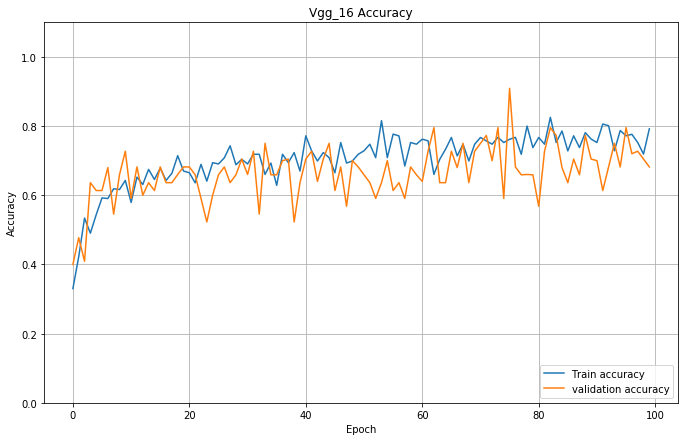

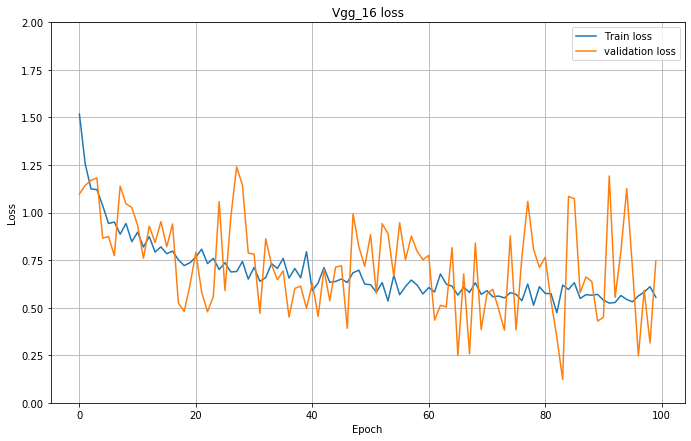

In [7]:
#PLOTTING RESULTS FOR VGG16 

import matplotlib.pyplot as plt
plt.figure(figsize=(25, 7))
plt.subplot(121)
plt.title("Vgg_16 Accuracy")
plt.plot(result.history['accuracy'], label='Train accuracy')
plt.plot(result.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.grid(True)

plt.figure(figsize=(25, 7))
plt.subplot(122)
plt.title("Vgg_16 loss")
plt.plot(result.history['loss'], label='Train loss')
plt.plot(result.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.legend(loc='upper right')
plt.grid(True)

### Baseline InceptionResNetV2


In [12]:
# CREATING A MODEL WITH INCEPTION AS BASE FEATURE EXTRACTOR
from keras.applications.inception_resnet_v2 import InceptionResNetV2
base_inception = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_inception.trainable = False

model_inception = Sequential()
model_inception.add(base_inception)
model_inception.add(Flatten())
model_inception.add(Dense(units=256, activation = 'relu'))
model_inception.add(Dropout(rate=0.25))
model_inception.add(Dense(units = 4, activation='softmax'))
model_inception.summary()


219062272/219055592 [==============================] - 10s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               9830656   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1028      
Total params: 64,168,420
Trainable params: 9,831,684
Non-trainable params: 54,336,736
_________________________________________________________________


In [13]:
#FIT INCEPTION MODEL FOR BASELINES
model_inception.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),loss = 'categorical_crossentropy', metrics = ['accuracy'])
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size


result_2 = model_inception.fit_generator(train_batches,steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=NUM_EPOCHS,validation_data=valid_batches,
                             validation_steps=STEP_SIZE_VALID)

Epoch 1/100


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 26s 1s/step - loss: 1.8689 - accuracy: 0.2621 - val_loss: 2.1457 - val_accuracy: 0.2800
Epoch 2/100
21/21 [==============================] - 6s 286ms/step - loss: 1.3614 - accuracy: 0.4417 - val_loss: 3.4602 - val_accuracy: 0.3182
Epoch 3/100
21/21 [==============================] - 5s 254ms/step - loss: 1.2430 - accuracy: 0.4417 - val_loss: 2.2177 - val_accuracy: 0.4545
Epoch 4/100
21/21 [==============================] - 5s 249ms/step - loss: 1.2336 - accuracy: 0.5000 - val_loss: 1.0779 - val_accuracy: 0.4318
Epoch 5/100
21/21 [==============================] - 5s 247ms/step - loss: 1.1503 - accuracy: 0.5050 - val_loss: 1.3681 - val_accuracy: 0.2500
Epoch 6/100
21/21 [==============================] - 5s 228ms/step - loss: 0.9999 - accuracy: 0.5922 - val_loss: 0.2768 - val_accuracy: 0.4545
Epoch 7/100
21/21 [==============================] - 5s 229ms/step - loss: 0.9193 - accuracy: 0.6019 - val_loss: 1.9977 - val_accuracy: 0.3600
Epoch 8/100
2

21/21 [==============================] - 5s 256ms/step - loss: 0.6852 - accuracy: 0.7184 - val_loss: 2.3418 - val_accuracy: 0.3182
Epoch 59/100
21/21 [==============================] - 5s 238ms/step - loss: 0.9227 - accuracy: 0.6359 - val_loss: 2.1119 - val_accuracy: 0.4091
Epoch 60/100
21/21 [==============================] - 5s 248ms/step - loss: 0.7343 - accuracy: 0.7000 - val_loss: 4.6712 - val_accuracy: 0.3864
Epoch 61/100
21/21 [==============================] - 5s 252ms/step - loss: 0.7474 - accuracy: 0.6553 - val_loss: 1.8026 - val_accuracy: 0.3200
Epoch 62/100
21/21 [==============================] - 6s 296ms/step - loss: 0.6333 - accuracy: 0.7427 - val_loss: 2.3214 - val_accuracy: 0.3636
Epoch 63/100
21/21 [==============================] - 5s 230ms/step - loss: 0.6062 - accuracy: 0.7621 - val_loss: 3.5053 - val_accuracy: 0.4091
Epoch 64/100
21/21 [==============================] - 6s 266ms/step - loss: 0.7191 - accuracy: 0.7030 - val_loss: 2.8836 - val_accuracy: 0.3636
Epoch

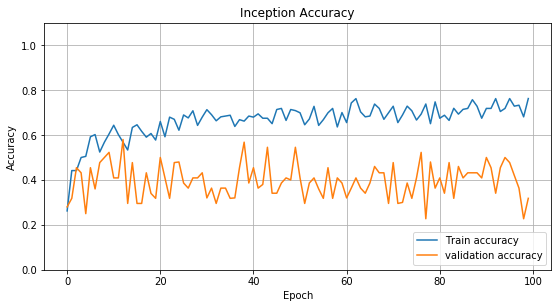

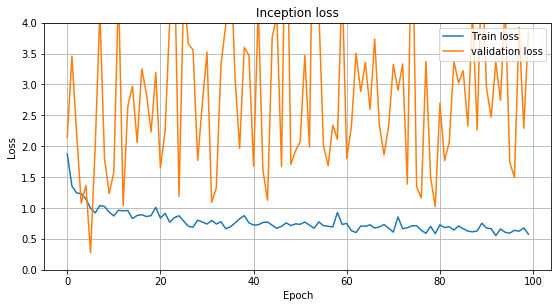

In [14]:
#PLOT RESULTS OF INCEPTION MODEL

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title("Inception Accuracy")
plt.plot(result_2.history['accuracy'], label='Train accuracy')
plt.plot(result_2.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.grid(True)

plt.figure(figsize=(20, 10))
plt.subplot(222)
plt.title("Inception loss")
plt.plot(result_2.history['loss'], label='Train loss')
plt.plot(result_2.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.legend(loc='upper right')
plt.grid(True)

### Baseline ResNet50

In [15]:
# CREATING A MODEL WITH RESNET50 AS BASE FEATURE EXTRACTOR

base_res = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_res.trainable = False
model_res = Sequential()
model_res.add(base_res)
model_res.add(Flatten())
model_res.add(Dense(units = 256, activation = 'relu'))
model_res.add(Dropout(rate=  0.25))
model_res.add(Dense(units=4, activation='softmax'))
model_res.summary()


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1028      
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
#FIT RESNET50 MODEL FOR BASELINES

model_res.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),loss = 'categorical_crossentropy', metrics = ['accuracy'])
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size


result_3 = model_res.fit_generator(train_batches,steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=NUM_EPOCHS,validation_data=valid_batches,
                             validation_steps=STEP_SIZE_VALID)

Epoch 1/100


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 10s 495ms/step - loss: 3.4756 - accuracy: 0.3641 - val_loss: 1.3565 - val_accuracy: 0.2600
Epoch 2/100
21/21 [==============================] - 7s 321ms/step - loss: 1.5652 - accuracy: 0.5388 - val_loss: 1.5029 - val_accuracy: 0.2955
Epoch 3/100
21/21 [==============================] - 6s 303ms/step - loss: 1.2043 - accuracy: 0.5777 - val_loss: 1.3883 - val_accuracy: 0.3182
Epoch 4/100
21/21 [==============================] - 6s 287ms/step - loss: 0.8769 - accuracy: 0.6095 - val_loss: 1.4991 - val_accuracy: 0.1818
Epoch 5/100
21/21 [==============================] - 5s 236ms/step - loss: 0.7527 - accuracy: 0.6733 - val_loss: 1.5574 - val_accuracy: 0.3409
Epoch 6/100
21/21 [==============================] - 5s 238ms/step - loss: 0.8002 - accuracy: 0.6262 - val_loss: 1.5383 - val_accuracy: 0.2273
Epoch 7/100
21/21 [==============================] - 6s 272ms/step - loss: 0.6615 - accuracy: 0.6810 - val_loss: 1.8838 - val_accuracy: 0.2600
Epoch 8/10

21/21 [==============================] - 4s 206ms/step - loss: 0.4969 - accuracy: 0.7767 - val_loss: 1.4314 - val_accuracy: 0.3636
Epoch 59/100
21/21 [==============================] - 5s 241ms/step - loss: 0.4374 - accuracy: 0.8010 - val_loss: 1.8536 - val_accuracy: 0.2045
Epoch 60/100
21/21 [==============================] - 5s 247ms/step - loss: 0.4736 - accuracy: 0.8252 - val_loss: 1.1611 - val_accuracy: 0.2727
Epoch 61/100
21/21 [==============================] - 5s 225ms/step - loss: 0.4751 - accuracy: 0.8447 - val_loss: 2.2989 - val_accuracy: 0.2800
Epoch 62/100
21/21 [==============================] - 6s 273ms/step - loss: 0.4858 - accuracy: 0.8010 - val_loss: 1.9096 - val_accuracy: 0.2273
Epoch 63/100
21/21 [==============================] - 5s 242ms/step - loss: 0.5168 - accuracy: 0.7670 - val_loss: 2.3282 - val_accuracy: 0.2500
Epoch 64/100
21/21 [==============================] - 5s 218ms/step - loss: 0.4874 - accuracy: 0.7913 - val_loss: 1.0452 - val_accuracy: 0.2955
Epoch

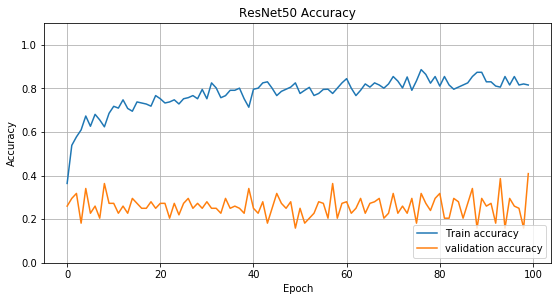

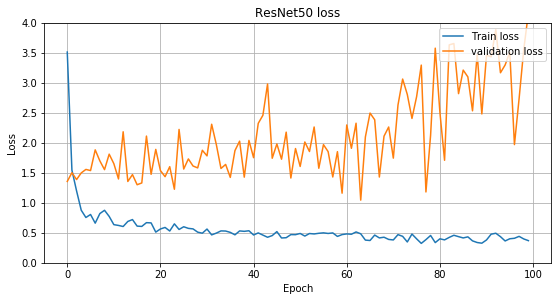

In [17]:
# PLOT RESULTS OF RESNET50

plt.figure(figsize=(20, 15))
plt.subplot(321)
plt.title("ResNet50 Accuracy")
plt.plot(result_3.history['accuracy'], label='Train accuracy')
plt.plot(result_3.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.grid(True)

plt.figure(figsize=(20, 15))
plt.subplot(322)
plt.title("ResNet50 loss")
plt.plot(result_3.history['loss'], label='Train loss')
plt.plot(result_3.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.legend(loc='upper right')
plt.grid(True)

### Baseline Xception


In [18]:
from keras.applications.xception import Xception

base_x = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_x.trainable = False
model_x = Sequential()
model_x.add(base_x)
model_x.add(Flatten())
model_x.add(Dense(units = 256, activation = 'relu'))
model_x.add(Dropout(rate=  0.25))
model_x.add(Dense(units=4, activation='softmax'))
model_x.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1028      
Total params: 46,552,876
Trainable params: 25,691,396
Non-trainable params: 20,861,480
_________________________________________________________________


In [19]:
#FIT Xception MODEL FOR BASELINES

model_x.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),loss = 'categorical_crossentropy', metrics = ['accuracy'])
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size


result_5 = model_x.fit_generator(train_batches,steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=NUM_EPOCHS,validation_data=valid_batches,
                             validation_steps=STEP_SIZE_VALID)

Epoch 1/100


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 7s 338ms/step - loss: 1.7081 - accuracy: 0.3835 - val_loss: 1.7057 - val_accuracy: 0.3000
Epoch 2/100
21/21 [==============================] - 6s 263ms/step - loss: 1.5120 - accuracy: 0.5340 - val_loss: 2.0387 - val_accuracy: 0.2500
Epoch 3/100
21/21 [==============================] - 6s 277ms/step - loss: 1.2555 - accuracy: 0.5243 - val_loss: 1.5840 - val_accuracy: 0.4091
Epoch 4/100
21/21 [==============================] - 5s 232ms/step - loss: 1.1248 - accuracy: 0.5243 - val_loss: 0.9061 - val_accuracy: 0.4773
Epoch 5/100
21/21 [==============================] - 5s 244ms/step - loss: 1.0307 - accuracy: 0.5857 - val_loss: 2.1759 - val_accuracy: 0.3636
Epoch 6/100
21/21 [==============================] - 4s 213ms/step - loss: 1.0942 - accuracy: 0.5743 - val_loss: 1.4576 - val_accuracy: 0.3409
Epoch 7/100
21/21 [==============================] - 5s 235ms/step - loss: 0.9506 - accuracy: 0.6117 - val_loss: 1.4121 - val_accuracy: 0.2800
Epoch 8/100

21/21 [==============================] - 5s 220ms/step - loss: 0.6190 - accuracy: 0.7624 - val_loss: 1.4411 - val_accuracy: 0.3409
Epoch 59/100
21/21 [==============================] - 6s 269ms/step - loss: 0.5606 - accuracy: 0.8095 - val_loss: 1.9130 - val_accuracy: 0.4318
Epoch 60/100
21/21 [==============================] - 5s 218ms/step - loss: 0.6068 - accuracy: 0.7427 - val_loss: 1.0362 - val_accuracy: 0.3864
Epoch 61/100
21/21 [==============================] - 5s 256ms/step - loss: 0.7412 - accuracy: 0.6942 - val_loss: 2.6810 - val_accuracy: 0.2800
Epoch 62/100
21/21 [==============================] - 6s 267ms/step - loss: 0.6217 - accuracy: 0.7573 - val_loss: 0.8291 - val_accuracy: 0.4545
Epoch 63/100
21/21 [==============================] - 5s 224ms/step - loss: 0.7040 - accuracy: 0.7039 - val_loss: 1.2742 - val_accuracy: 0.3636
Epoch 64/100
21/21 [==============================] - 5s 238ms/step - loss: 0.5257 - accuracy: 0.7816 - val_loss: 1.6654 - val_accuracy: 0.4773
Epoch

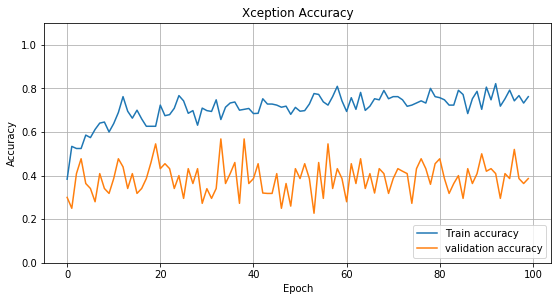

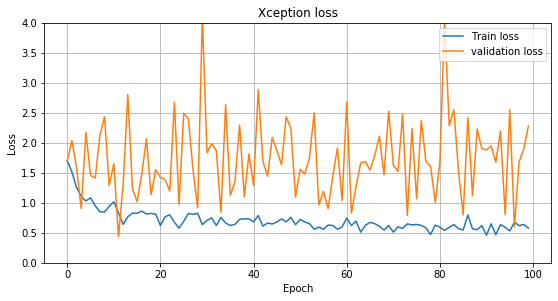

In [20]:
# PLOT RESULTS OF XCEPTION

plt.figure(figsize=(20, 15))
plt.subplot(321)
plt.title("Xception Accuracy")
plt.plot(result_5.history['accuracy'], label='Train accuracy')
plt.plot(result_5.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.grid(True)

plt.figure(figsize=(20, 15))
plt.subplot(322)
plt.title("Xception loss")
plt.plot(result_5.history['loss'], label='Train loss')
plt.plot(result_5.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.legend(loc='upper right')
plt.grid(True)

### Baseline Self Created 

In [5]:
# CREATED MY OWN CNN ARCHITECTURE 

model_own = Sequential()
model_own.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model_own.add(MaxPool2D(pool_size=(2,2)))
model_own.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model_own.add(MaxPool2D(pool_size=(2,2)))
model_own.add(Flatten())
model_own.add(Dense(units = 128, activation = 'relu'))
model_own.add(Dropout(rate=  0.25))
model_own.add(Dense(units = 64, activation = 'relu'))
model_own.add(Dropout(rate=  0.25))
model_own.add(Dense(units=4, activation='softmax'))

model_own.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               23888000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [6]:
# FITTING MY OWN MODEL FOR BASELINES

model_own.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),loss = 'categorical_crossentropy', metrics = ['accuracy'])
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size


result_4 = model_own.fit_generator(train_batches,steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=NUM_EPOCHS,validation_data=valid_batches,
                             validation_steps=STEP_SIZE_VALID)

Epoch 1/100


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 7s 313ms/step - loss: 1.5173 - accuracy: 0.2427 - val_loss: 1.4098 - val_accuracy: 0.2400
Epoch 2/100
21/21 [==============================] - 5s 250ms/step - loss: 1.4080 - accuracy: 0.2718 - val_loss: 1.3565 - val_accuracy: 0.3182
Epoch 3/100
21/21 [==============================] - 5s 223ms/step - loss: 1.3932 - accuracy: 0.2427 - val_loss: 1.3733 - val_accuracy: 0.3409
Epoch 4/100
21/21 [==============================] - 5s 234ms/step - loss: 1.3833 - accuracy: 0.2816 - val_loss: 1.3615 - val_accuracy: 0.3182
Epoch 5/100
21/21 [==============================] - 4s 205ms/step - loss: 1.3778 - accuracy: 0.2524 - val_loss: 1.3459 - val_accuracy: 0.3182
Epoch 6/100
21/21 [==============================] - 4s 204ms/step - loss: 1.3870 - accuracy: 0.2524 - val_loss: 1.4427 - val_accuracy: 0.2727
Epoch 7/100
21/21 [==============================] - 5s 222ms/step - loss: 1.3820 - accuracy: 0.2476 - val_loss: 1.4049 - val_accuracy: 0.2600
Epoch 8/100

21/21 [==============================] - 4s 213ms/step - loss: 1.0583 - accuracy: 0.5243 - val_loss: 0.9974 - val_accuracy: 0.5909
Epoch 59/100
21/21 [==============================] - 5s 225ms/step - loss: 0.9661 - accuracy: 0.6165 - val_loss: 0.8155 - val_accuracy: 0.5455
Epoch 60/100
21/21 [==============================] - 4s 200ms/step - loss: 1.0337 - accuracy: 0.4952 - val_loss: 1.6026 - val_accuracy: 0.5227
Epoch 61/100
21/21 [==============================] - 4s 210ms/step - loss: 1.1029 - accuracy: 0.4709 - val_loss: 1.0901 - val_accuracy: 0.6000
Epoch 62/100
21/21 [==============================] - 5s 253ms/step - loss: 1.0390 - accuracy: 0.5248 - val_loss: 0.9195 - val_accuracy: 0.5455
Epoch 63/100
21/21 [==============================] - 4s 205ms/step - loss: 0.9718 - accuracy: 0.5534 - val_loss: 1.0491 - val_accuracy: 0.6136
Epoch 64/100
21/21 [==============================] - 4s 211ms/step - loss: 0.9878 - accuracy: 0.5857 - val_loss: 1.0386 - val_accuracy: 0.5909
Epoch

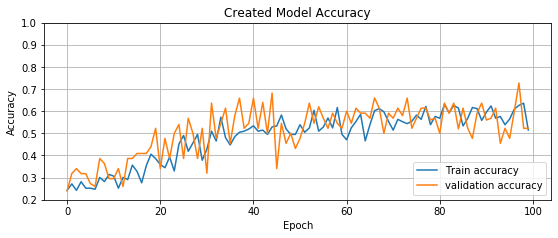

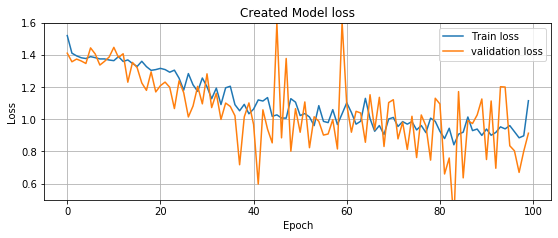

In [9]:
#PLOT RESULTS OF MY MODEL

plt.figure(figsize=(20, 15))
plt.subplot(421)
plt.title("Created Model Accuracy")
plt.plot(result_4.history['accuracy'], label='Train accuracy')
plt.plot(result_4.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
plt.grid(True)

plt.figure(figsize=(20, 15))
plt.subplot(422)
plt.title("Created Model loss")
plt.plot(result_4.history['loss'], label='Train loss')
plt.plot(result_4.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.5,1.6)
plt.legend(loc='upper right')
plt.grid(True)

Among the four pretrained models VGG16 had a decent traning and validation accuracy in the range of 70% to 80%.
InceptionResNetV2 had good traning accuracy at around 80% but pool validation accuracy at around 30%
ResNet50 had good training accuracy at around 80% but very poor validation accuracy at around 40%. 
Xception had a trainnig accuracy of around 80% and validation accuracy at around 40%
The model we created and trained on this dataset had very low training and validation accuracy around 20% to 35%

Following these baselines, we decided to go ahead with VGG16 model and Xception model and further parameter tune it in an attempt to get a better result.



# Tuning VGG16

In this section, we used VGG16 as my base feature extractor and used GridSearchCV to parameter tune to determine the best "Activation fucntion", "Dropout" and  "Learning Rate". We did this over 3 folds and used early stopping to make the process faster. We tried 2 differnet activation fucntions, 3 differnet value for dropouts, and 3 different values for learning rates.


In [23]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience= 10)

def build_classifier(activation,dropout):
  conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  conv_base.trainable = False
  classifier = Sequential()
  classifier.add(conv_base)
  classifier.add(Flatten())
  classifier.add(Dense(units = 256, activation = activation))
  classifier.add(Dropout(dropout))
  classifier.add(Dense(units=4, activation='softmax'))
  classifier.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),loss='categorical_crossentropy',metrics=["accuracy"])
  return classifier

param = {'activation' : ['sigmoid','relu'],
        'dropout' : [0.15,0.20,0.25],
        'epochs' : [120]}

clf = KerasClassifier(build_classifier)
X_train, y_train = train_batches.next()
X_val, y_val = valid_batches.next()
print(train_batches.class_indices)
print(valid_batches.class_indices)

grid = GridSearchCV(estimator=clf, param_grid=param,verbose=1,cv=3)
grid.fit(X_train,y_train,callbacks=[es])


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/120
6/6 [==============================] - 0s 28ms/step - loss: 2.0848 - accuracy: 0.1667
Epoch 2/120
6/6 [==============================] - 0s 5ms/step - loss: 1.0470 - accuracy: 0.5000
Epoch 3/120
6/6 [==============================] - 0s 5ms/step - loss: 0.7778 - accuracy: 1.0000
Epoch 4/120
6/6 [==============================] - 0s 5ms/step - loss: 0.5082 - accuracy: 1.0000
Epoch 5/120
6/6 [==============================] - 0s 5ms/step - loss: 0.5365 - accuracy: 0.8333
Epoch 6/120
6/6 [==============================] - 0s 5ms/step - loss: 0.3547 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 5ms/step - loss: 0.3115 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 5ms/step - loss: 0.2067 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 5ms/step - loss: 0.1580 - accuracy: 1.0000
Epoch 10/120
6/6 [==============================] - 0s 5ms/step - loss: 0.1363 - accuracy: 1.0000
Epoch 11/120
6/6 [==========

Epoch 15/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0614 - accuracy: 1.0000
Epoch 16/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 1.0000
Epoch 17/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0569 - accuracy: 1.0000
Epoch 18/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0528 - accuracy: 1.0000
Epoch 19/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0332 - accuracy: 1.0000
Epoch 20/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0409 - accuracy: 1.0000
Epoch 21/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0318 - accuracy: 1.0000
Epoch 22/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0332 - accuracy: 1.0000
Epoch 23/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 24/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0241 - accuracy: 1.0000
Epoch 25/120
7/7 [==

Epoch 37/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 38/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 39/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 40/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 41/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 42/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 43/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 44/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 45/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 46/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 47/120
7/7 [==

Epoch 60/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 61/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 62/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 63/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 64/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 65/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 66/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 67/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 68/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 69/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 70/120
6/6 [==

Epoch 61/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 62/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 63/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 64/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 65/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 66/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 00066: early stopping
3/3 [==============================] - 0s 26ms/step
Epoch 1/120
7/7 [==============================] - 0s 25ms/step - loss: 1.9837 - accuracy: 0.2857
Epoch 2/120
7/7 [==============================] - 0s 4ms/step - loss: 1.1763 - accuracy: 0.5714
Epoch 3/120
7/7 [==============================] - 0s 5ms/step - loss: 0.9071 - accuracy: 0.5714
Epoch 4/120
7/7 [=======================

Epoch 78/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 79/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 80/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 81/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 82/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 83/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 84/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0098 - accuracy: 1.0000
Epoch 85/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 00085: early stopping
3/3 [==============================] - 0s 26ms/step
Epoch 1/120
6/6 [==============================] - 0s 28ms/step - loss: 1.8275 - accuracy: 0.1667
Epoch 2/120
6/6 [=====================

7/7 [==============================] - 0s 4ms/step - loss: 0.0197 - accuracy: 1.0000
Epoch 27/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0248 - accuracy: 1.0000
Epoch 28/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0286 - accuracy: 1.0000
Epoch 29/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0222 - accuracy: 1.0000
Epoch 30/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0261 - accuracy: 1.0000
Epoch 31/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0349 - accuracy: 1.0000
Epoch 32/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0132 - accuracy: 1.0000
Epoch 33/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0113 - accuracy: 1.0000
Epoch 34/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 35/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0104 - accuracy: 1.0000
Epoch 36/120
7/7 [===============

Epoch 30/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0168 - accuracy: 1.0000
Epoch 31/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 32/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0223 - accuracy: 1.0000
Epoch 33/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 34/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0109 - accuracy: 1.0000
Epoch 35/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0161 - accuracy: 1.0000
Epoch 36/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 37/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 38/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 39/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 40/120
7/7 [==

Epoch 47/120
6/6 [==============================] - 0s 5ms/step - loss: 8.3481e-05 - accuracy: 1.0000
Epoch 48/120
6/6 [==============================] - 0s 5ms/step - loss: 2.2881e-04 - accuracy: 1.0000
Epoch 49/120
6/6 [==============================] - 0s 5ms/step - loss: 1.4582e-04 - accuracy: 1.0000
Epoch 50/120
6/6 [==============================] - 0s 5ms/step - loss: 2.6538e-04 - accuracy: 1.0000
Epoch 51/120
6/6 [==============================] - 0s 5ms/step - loss: 2.1268e-04 - accuracy: 1.0000
Epoch 52/120
6/6 [==============================] - 0s 5ms/step - loss: 1.6552e-04 - accuracy: 1.0000
Epoch 53/120
6/6 [==============================] - 0s 5ms/step - loss: 3.8429e-04 - accuracy: 1.0000
Epoch 54/120
6/6 [==============================] - 0s 5ms/step - loss: 5.1301e-04 - accuracy: 1.0000
Epoch 55/120
6/6 [==============================] - 0s 5ms/step - loss: 1.5154e-04 - accuracy: 1.0000
Epoch 56/120
6/6 [==============================] - 0s 5ms/step - loss: 1.5089e-04

Epoch 27/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 28/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 29/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 30/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 31/120
7/7 [==============================] - 0s 4ms/step - loss: 9.7247e-04 - accuracy: 1.0000
Epoch 32/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 33/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 34/120
7/7 [==============================] - 0s 4ms/step - loss: 6.0378e-04 - accuracy: 1.0000
Epoch 35/120
7/7 [==============================] - 0s 4ms/step - loss: 8.6743e-04 - accuracy: 1.0000
Epoch 36/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 37

Epoch 56/120
6/6 [==============================] - 0s 4ms/step - loss: 5.0207e-04 - accuracy: 1.0000
Epoch 00056: early stopping
4/4 [==============================] - 0s 20ms/step
Epoch 1/120
7/7 [==============================] - 0s 26ms/step - loss: 1.3488 - accuracy: 0.4286
Epoch 2/120
7/7 [==============================] - 0s 4ms/step - loss: 0.8228 - accuracy: 0.5714
Epoch 3/120
7/7 [==============================] - 0s 4ms/step - loss: 0.5050 - accuracy: 1.0000
Epoch 4/120
7/7 [==============================] - 0s 4ms/step - loss: 0.3295 - accuracy: 1.0000
Epoch 5/120
7/7 [==============================] - 0s 4ms/step - loss: 0.2412 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 4ms/step - loss: 0.1079 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 4ms/step - loss: 0.1060 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0580 - accuracy: 1.0000
Epoch 9/120
7/7 [========================

7/7 [==============================] - 0s 4ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0134 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 15/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 16/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 17/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 18/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 19/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 20/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 21/120
7/7 [===============

Epoch 30/120
6/6 [==============================] - 0s 5ms/step - loss: 7.6306e-04 - accuracy: 1.0000
Epoch 31/120
6/6 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 32/120
6/6 [==============================] - 0s 5ms/step - loss: 2.2253e-04 - accuracy: 1.0000
Epoch 33/120
6/6 [==============================] - 0s 5ms/step - loss: 6.3969e-04 - accuracy: 1.0000
Epoch 34/120
6/6 [==============================] - 0s 5ms/step - loss: 5.3850e-04 - accuracy: 1.0000
Epoch 35/120
6/6 [==============================] - 0s 5ms/step - loss: 9.7124e-04 - accuracy: 1.0000
Epoch 36/120
6/6 [==============================] - 0s 5ms/step - loss: 7.2842e-04 - accuracy: 1.0000
Epoch 37/120
6/6 [==============================] - 0s 5ms/step - loss: 2.9233e-04 - accuracy: 1.0000
Epoch 38/120
6/6 [==============================] - 0s 5ms/step - loss: 5.3682e-04 - accuracy: 1.0000
Epoch 39/120
6/6 [==============================] - 0s 5ms/step - loss: 2.8098e-04 - a

Epoch 5/120
7/7 [==============================] - 0s 4ms/step - loss: 0.3196 - accuracy: 0.8571
Epoch 6/120
7/7 [==============================] - 0s 4ms/step - loss: 0.3213 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0800 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0910 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 4ms/step - loss: 0.1362 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0298 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0246 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0312 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0215 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0260 - accuracy: 1.0000
Epoch 15/120
7/7 [=======

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.2min finished
/share/pkg.7/python3/3.6.9/install/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/120
10/10 [==============================] - 0s 18ms/step - loss: 1.5403 - accuracy: 0.3000
Epoch 2/120
10/10 [==============================] - 0s 4ms/step - loss: 1.2256 - accuracy: 0.5000
Epoch 3/120
10/10 [==============================] - 0s 4ms/step - loss: 0.9450 - accuracy: 0.5000
Epoch 4/120
10/10 [==============================] - 0s 4ms/step - loss: 0.7311 - accuracy: 0.8000
Epoch 5/120
10/10 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.9000
Epoch 6/120
10/10 [==============================] - 0s 4ms/step - loss: 0.4025 - accuracy: 1.0000
Epoch 7/120
10/10 [==============================] - 0s 4ms/step - loss: 0.3634 - accuracy: 1.0000
Epoch 8/120
10/10 [==============================] - 0s 4ms/step - loss: 0.3316 - accuracy: 1.0000
Epoch 9/120
10/10 [==============================] - 0s 4ms/step - loss: 0.2663 - accuracy: 1.0000
Epoch 10/120
10/10 [==============================] - 0s 4ms/step - loss: 0.2055 - accuracy: 1.0000
Epoch 11

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x2ab74e0aedd8>,
             iid='warn', n_jobs=None,
             param_grid={'activation': ['sigmoid', 'relu'],
                         'dropout': [0.15, 0.2, 0.25], 'epochs': [120]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [24]:
print(grid.best_params_)
print(grid.best_score_)

{'activation': 'sigmoid', 'dropout': 0.15, 'epochs': 120}
0.5000000059604645


In [30]:
def build_estimator(learning_rate):
  base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  base.trainable = False
  estimator = Sequential()
  estimator.add(base)
  estimator.add(Flatten())
  estimator.add(Dense(units = 256, activation = 'sigmoid'))
  estimator.add(Dropout(rate = 0.15))
  estimator.add(Dense(units=4, activation='softmax'))
  estimator.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=["accuracy"])
  return estimator


param2 = {'learning_rate' : [0.0001,0.001,0.00001],
         'epochs' : [120]}

est = KerasClassifier(build_estimator)
X_train, y_train = train_batches.next()
X_val, y_val = valid_batches.next()
print(train_batches.class_indices)
print(valid_batches.class_indices)

grid2 = GridSearchCV(estimator=est, param_grid=param2 ,verbose=1,cv=3)
grid2.fit(X_train,y_train,callbacks=[es])

{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/120
6/6 [==============================] - 0s 28ms/step - loss: 1.7477 - accuracy: 0.1667
Epoch 2/120
6/6 [==============================] - 0s 5ms/step - loss: 1.1442 - accuracy: 0.5000
Epoch 3/120
6/6 [==============================] - 0s 5ms/step - loss: 0.8546 - accuracy: 0.5000
Epoch 4/120
6/6 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 1.0000
Epoch 5/120
6/6 [==============================] - 0s 5ms/step - loss: 0.5604 - accuracy: 1.0000
Epoch 6/120
6/6 [==============================] - 0s 5ms/step - loss: 0.4215 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 5ms/step - loss: 0.4654 - accuracy: 0.8333
Epoch 8/120
6/6 [==============================] - 0s 5ms/step - loss: 0.3277 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 5ms/step - loss: 0.1973 - accuracy: 1.0000
Epoch 10/120
6/6 [==============================] - 0s 5ms/step - loss: 0.1753 - accuracy: 1.0000
Epoch 11/120
6/6 [==========

Epoch 26/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0225 - accuracy: 1.0000
Epoch 27/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0244 - accuracy: 1.0000
Epoch 28/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0292 - accuracy: 1.0000
Epoch 29/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0147 - accuracy: 1.0000
Epoch 30/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0189 - accuracy: 1.0000
Epoch 31/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 1.0000
Epoch 32/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0156 - accuracy: 1.0000
Epoch 33/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0166 - accuracy: 1.0000
Epoch 34/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0117 - accuracy: 1.0000
Epoch 35/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0138 - accuracy: 1.0000
Epoch 36/120
7/7 [==

Epoch 42/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0161 - accuracy: 1.0000
Epoch 43/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0152 - accuracy: 1.0000
Epoch 44/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0147 - accuracy: 1.0000
Epoch 45/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0150 - accuracy: 1.0000
Epoch 46/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0167 - accuracy: 1.0000
Epoch 47/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0102 - accuracy: 1.0000
Epoch 48/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0119 - accuracy: 1.0000
Epoch 49/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0134 - accuracy: 1.0000
Epoch 50/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0111 - accuracy: 1.0000
Epoch 51/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0154 - accuracy: 1.0000
Epoch 52/120
7/7 [==

Epoch 56/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 57/120
6/6 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 58/120
6/6 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 59/120
6/6 [==============================] - 0s 5ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 60/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 61/120
6/6 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 62/120
6/6 [==============================] - 0s 5ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 63/120
6/6 [==============================] - 0s 5ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 64/120
6/6 [==============================] - 0s 4ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 65/120
6/6 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 66/120
6/6 [==

Epoch 72/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 73/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 74/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 75/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 76/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 77/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 78/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 79/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 80/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 81/120
7/7 [==============================] - 0s 4ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 82/120
7/7 [==

Epoch 8/120
6/6 [==============================] - 0s 5ms/step - loss: 1.3211 - accuracy: 0.5000
Epoch 9/120
6/6 [==============================] - 0s 4ms/step - loss: 1.5408 - accuracy: 0.3333
Epoch 10/120
6/6 [==============================] - 0s 5ms/step - loss: 1.2525 - accuracy: 0.3333
Epoch 11/120
6/6 [==============================] - 0s 4ms/step - loss: 1.0090 - accuracy: 0.6667
Epoch 12/120
6/6 [==============================] - 0s 4ms/step - loss: 1.1644 - accuracy: 0.6667
Epoch 13/120
6/6 [==============================] - 0s 4ms/step - loss: 1.1034 - accuracy: 0.5000
Epoch 14/120
6/6 [==============================] - 0s 5ms/step - loss: 0.9903 - accuracy: 0.8333
Epoch 15/120
6/6 [==============================] - 0s 4ms/step - loss: 1.2408 - accuracy: 0.5000
Epoch 16/120
6/6 [==============================] - 0s 5ms/step - loss: 0.9849 - accuracy: 0.5000
Epoch 17/120
6/6 [==============================] - 0s 4ms/step - loss: 1.0879 - accuracy: 0.6667
Epoch 18/120
6/6 [====

Epoch 29/120
7/7 [==============================] - 0s 4ms/step - loss: 0.8092 - accuracy: 0.8571
Epoch 30/120
7/7 [==============================] - 0s 4ms/step - loss: 0.7792 - accuracy: 0.8571
Epoch 31/120
7/7 [==============================] - 0s 4ms/step - loss: 0.8382 - accuracy: 0.8571
Epoch 32/120
7/7 [==============================] - 0s 4ms/step - loss: 0.8152 - accuracy: 0.7143
Epoch 33/120
7/7 [==============================] - 0s 4ms/step - loss: 0.7907 - accuracy: 0.8571
Epoch 34/120
7/7 [==============================] - 0s 4ms/step - loss: 0.8075 - accuracy: 0.5714
Epoch 35/120
7/7 [==============================] - 0s 4ms/step - loss: 0.7548 - accuracy: 0.7143
Epoch 36/120
7/7 [==============================] - 0s 4ms/step - loss: 0.7006 - accuracy: 0.8571
Epoch 37/120
7/7 [==============================] - 0s 4ms/step - loss: 0.7638 - accuracy: 0.7143
Epoch 38/120
7/7 [==============================] - 0s 4ms/step - loss: 0.7564 - accuracy: 0.7143
Epoch 39/120
7/7 [==

Epoch 38/120
7/7 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 1.0000
Epoch 39/120
7/7 [==============================] - 0s 4ms/step - loss: 0.4583 - accuracy: 1.0000
Epoch 40/120
7/7 [==============================] - 0s 4ms/step - loss: 0.5811 - accuracy: 1.0000
Epoch 41/120
7/7 [==============================] - 0s 4ms/step - loss: 0.4830 - accuracy: 1.0000
Epoch 42/120
7/7 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 1.0000
Epoch 43/120
7/7 [==============================] - 0s 4ms/step - loss: 0.5125 - accuracy: 1.0000
Epoch 44/120
7/7 [==============================] - 0s 4ms/step - loss: 0.4512 - accuracy: 1.0000
Epoch 45/120
7/7 [==============================] - 0s 4ms/step - loss: 0.5405 - accuracy: 1.0000
Epoch 46/120
7/7 [==============================] - 0s 4ms/step - loss: 0.4550 - accuracy: 0.8571
Epoch 47/120
7/7 [==============================] - 0s 4ms/step - loss: 0.4207 - accuracy: 1.0000
Epoch 48/120
7/7 [==

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.8s finished


Epoch 1/120
10/10 [==============================] - 0s 19ms/step - loss: 2.2276 - accuracy: 0.1000
Epoch 2/120
10/10 [==============================] - 0s 4ms/step - loss: 1.5444 - accuracy: 0.2000
Epoch 3/120
10/10 [==============================] - 0s 4ms/step - loss: 1.0396 - accuracy: 0.7000
Epoch 4/120
10/10 [==============================] - 0s 4ms/step - loss: 1.0110 - accuracy: 0.7000
Epoch 5/120
10/10 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.5000
Epoch 6/120
10/10 [==============================] - 0s 4ms/step - loss: 0.9350 - accuracy: 0.6000
Epoch 7/120
10/10 [==============================] - 0s 4ms/step - loss: 0.8691 - accuracy: 0.5000
Epoch 8/120
10/10 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.7000
Epoch 9/120
10/10 [==============================] - 0s 4ms/step - loss: 0.5826 - accuracy: 0.9000
Epoch 10/120
10/10 [==============================] - 0s 4ms/step - loss: 0.4290 - accuracy: 1.0000
Epoch 11

10/10 [==============================] - 0s 4ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 84/120
10/10 [==============================] - 0s 4ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 85/120
10/10 [==============================] - 0s 4ms/step - loss: 0.0098 - accuracy: 1.0000
Epoch 86/120
10/10 [==============================] - 0s 4ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 87/120
10/10 [==============================] - 0s 4ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 88/120
10/10 [==============================] - 0s 4ms/step - loss: 0.0090 - accuracy: 1.0000
Epoch 89/120
10/10 [==============================] - 0s 4ms/step - loss: 0.0096 - accuracy: 1.0000
Epoch 90/120
10/10 [==============================] - 0s 4ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 91/120
10/10 [==============================] - 0s 4ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 92/120
10/10 [==============================] - 0s 4ms/step - loss: 0.0104 - accuracy: 1.0000
Epoch 93/120


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x2abd7bbc63c8>,
             iid='warn', n_jobs=None,
             param_grid={'epochs': [120],
                         'learning_rate': [0.0001, 0.001, 1e-05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [115]:
print(grid2.best_params_)

{'epochs': 120, 'learning_rate': 0.0001}


In the following section we created a model with VGG16 and the parameters we tuned above. we then trained this model with tuned parameters on the training set and used ModelCheckpoints to optimize on the validation set. We saved only those weights which maximized the validation accuracy. Later, we loaded those weights into my model before running it on the test set.

In [58]:
model = Sequential()
model_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_base.trainable = False
model.add(model_base)
model.add(Flatten())
model.add(Dense(units = 256, activation = 'sigmoid'))
model.add(Dropout(rate=0.15))
model.add(Dense(units=4, activation='softmax'))


In [44]:
mc = ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#st = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience= 20)

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=["accuracy"])

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

fin_mod = model.fit_generator(train_batches,steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=150,validation_data=valid_batches,
                             validation_steps=STEP_SIZE_VALID,callbacks=[mc])

Epoch 1/150


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 5s 232ms/step - loss: 0.7696 - accuracy: 0.6893 - val_loss: 0.4804 - val_accuracy: 0.6000

Epoch 00001: val_accuracy improved from -inf to 0.60000, saving model to best_model_task2.h5
Epoch 2/150
21/21 [==============================] - 5s 252ms/step - loss: 0.7030 - accuracy: 0.6990 - val_loss: 0.7662 - val_accuracy: 0.6591

Epoch 00002: val_accuracy improved from 0.60000 to 0.65909, saving model to best_model_task2.h5
Epoch 3/150
21/21 [==============================] - 5s 237ms/step - loss: 0.6986 - accuracy: 0.7136 - val_loss: 0.8004 - val_accuracy: 0.7045

Epoch 00003: val_accuracy improved from 0.65909 to 0.70455, saving model to best_model_task2.h5
Epoch 4/150
21/21 [==============================] - 5s 232ms/step - loss: 0.7261 - accuracy: 0.6796 - val_loss: 0.9040 - val_accuracy: 0.5909

Epoch 00004: val_accuracy did not improve from 0.70455
Epoch 5/150
21/21 [==============================] - 5s 220ms/step - loss: 0.6701 - accuracy: 0.

21/21 [==============================] - 5s 223ms/step - loss: 0.4704 - accuracy: 0.8058 - val_loss: 0.4155 - val_accuracy: 0.6591

Epoch 00081: val_accuracy did not improve from 0.81818
Epoch 82/150
21/21 [==============================] - 5s 221ms/step - loss: 0.6097 - accuracy: 0.7233 - val_loss: 0.7526 - val_accuracy: 0.7045

Epoch 00082: val_accuracy did not improve from 0.81818
Epoch 83/150
21/21 [==============================] - 4s 203ms/step - loss: 0.4580 - accuracy: 0.8069 - val_loss: 0.4721 - val_accuracy: 0.6591

Epoch 00083: val_accuracy did not improve from 0.81818
Epoch 84/150
21/21 [==============================] - 5s 215ms/step - loss: 0.4974 - accuracy: 0.7762 - val_loss: 1.5679 - val_accuracy: 0.5909

Epoch 00084: val_accuracy did not improve from 0.81818
Epoch 85/150
21/21 [==============================] - 5s 228ms/step - loss: 0.4313 - accuracy: 0.8252 - val_loss: 0.9186 - val_accuracy: 0.7200

Epoch 00085: val_accuracy did not improve from 0.81818
Epoch 86/150



Epoch 00121: val_accuracy did not improve from 0.86364
Epoch 122/150
21/21 [==============================] - 5s 257ms/step - loss: 0.5079 - accuracy: 0.7767 - val_loss: 0.1474 - val_accuracy: 0.7045

Epoch 00122: val_accuracy did not improve from 0.86364
Epoch 123/150
21/21 [==============================] - 5s 224ms/step - loss: 0.3916 - accuracy: 0.8252 - val_loss: 1.0559 - val_accuracy: 0.6136

Epoch 00123: val_accuracy did not improve from 0.86364
Epoch 124/150
21/21 [==============================] - 15s 698ms/step - loss: 0.4714 - accuracy: 0.7921 - val_loss: 0.7869 - val_accuracy: 0.7273

Epoch 00124: val_accuracy did not improve from 0.86364
Epoch 125/150
21/21 [==============================] - 6s 282ms/step - loss: 0.4257 - accuracy: 0.8286 - val_loss: 0.7956 - val_accuracy: 0.7273

Epoch 00125: val_accuracy did not improve from 0.86364
Epoch 126/150
21/21 [==============================] - 4s 202ms/step - loss: 0.4411 - accuracy: 0.8168 - val_loss: 0.6937 - val_accuracy: 0

In [60]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_43 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_121 (Dense)            (None, 256)               6422784   
_________________________________________________________________
dropout_79 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 4)                 1028      
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________


### Plot Accuracy and Loss During Training

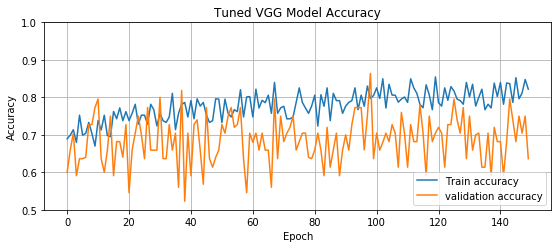

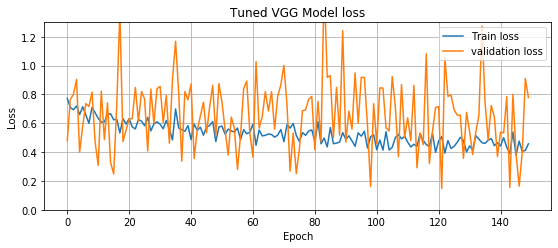

In [127]:
#PLOT FOR TUNED MODEL VGG16 MODEL
plt.figure(figsize=(20, 20))
plt.subplot(521)
plt.title("Tuned VGG Model Accuracy")
plt.plot(fin_mod.history['accuracy'], label='Train accuracy')
plt.plot(fin_mod.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.grid(True)

plt.figure(figsize=(20, 20))
plt.subplot(522)
plt.title("Tuned VGG Model loss")
plt.plot(fin_mod.history['loss'], label='Train loss')
plt.plot(fin_mod.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1.3)
plt.legend(loc='upper right')
plt.grid(True)

#### Testing Model

In [61]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

model.load_weights("best_model_task2.h5")

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=44,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 1s 23ms/step
Test loss: 0.5879592299461365
Test accuracy: 0.7222222089767456


## Lower Dimension Plot

In [66]:
from sklearn.manifold import TSNE

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_121').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")


logits = intermediate_layer_model.predict_generator(tsne_eval_generator,verbose=1,steps = 270)

tsne = TSNE(n_components=2, init='random', random_state = 49) 
print(logits.shape)
tsne_obj = tsne.fit_transform(logits)



Found 270 images belonging to 4 classes.
270/270 [==============================] - 4s 15ms/step
(270, 256)


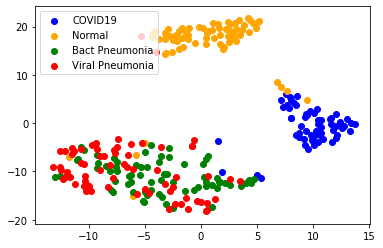

In [67]:

x1=[]
y1=[]

x2=[]
y2=[]

x3=[]
y3=[]

x4=[]
y4=[]


for i in range(tsne_obj.shape[0]):
    if(tsne_eval_generator.labels[i]==0):
        x1.append(tsne_obj[i,0])
        y1.append(tsne_obj[i,1])
    elif(tsne_eval_generator.labels[i]==1):
        x2.append(tsne_obj[i,0])
        y2.append(tsne_obj[i,1])
    elif(tsne_eval_generator.labels[i]==2):
        x3.append(tsne_obj[i,0])
        y3.append(tsne_obj[i,1])
    elif(tsne_eval_generator.labels[i]==3):
        x4.append(tsne_obj[i,0])
        y4.append(tsne_obj[i,1])

plt.scatter(x1,y1,c='blue',label = 'COVID19')
plt.scatter(x2,y2,c='orange',label = 'Normal')
plt.scatter(x3,y3,c='green',label = 'Bact Pneumonia')
plt.scatter(x4,y4,c='red',label = 'Viral Pneumonia')

plt.legend()

# Tuning XCEPTION

In this section, we used Xception as our base feature extractor and used GridSearchCV to parameter tune to determine the best "Activation fucntion", "Dropout" and  "Learning Rate".  we tried 2 differnet activation fucntions, 4 differnet value for dropouts, and 3 different values for learning rates and used 3 folds for it.


In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

#stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience= 20)

def build_xception(activation,dropout):
    conv_base = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable = False
    classifier = Sequential()
    classifier.add(conv_base)
    classifier.add(Flatten())
    classifier.add(Dense(units = 256, activation = activation))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(units = 128, activation= activation))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(units=4, activation='softmax'))
    classifier.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),loss='categorical_crossentropy',metrics=["accuracy"])
    return classifier

param_3 = {'activation' : ['relu','sigmoid'],
        'dropout' : [0.15,0.20,0.25,0.30],
        'epochs' : [120]}

clf_2 = KerasClassifier(build_xception)
X_train, y_train = train_batches.next()
X_val, y_val = valid_batches.next()
print(train_batches.class_indices)
print(valid_batches.class_indices)

grid_3 = GridSearchCV(estimator=clf_2, param_grid=param_3,verbose=1,cv=3)
grid_3.fit(X_train,y_train)

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/120
6/6 [==============================] - 1s 244ms/step - loss: 1.5368 - accuracy: 0.3333
Epoch 2/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3309 - accuracy: 1.0000
Epoch 3/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1166 - accuracy: 1.0000
Epoch 4/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 5/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0077 - accuracy: 1.0000


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 6/120
6/6 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 7ms/step - loss: 0.0245 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 8ms/step - loss: 2.6429e-04 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 1.0689e-04 - accuracy: 1.0000
Epoch 10/120
6/6 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 1.8278e-05 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 8ms/step - loss: 4.7715e-04 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 7ms/step - loss: 6.1374e-04 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 7ms/step - loss: 8.6226e-06 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 7ms/step - loss: 5.9889e-04 - accuracy: 1.0

Epoch 87/120
6/6 [==============================] - 0s 7ms/step - loss: 6.9539e-07 - accuracy: 1.0000
Epoch 88/120
6/6 [==============================] - 0s 7ms/step - loss: 2.0265e-06 - accuracy: 1.0000
Epoch 89/120
6/6 [==============================] - 0s 8ms/step - loss: 2.6701e-05 - accuracy: 1.0000
Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 1.1921e-07 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 7ms/step - loss: 1.9868e-07 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 7ms/step - loss: 5.9605e-08 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 7ms/step - loss: 3.9140e-06 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 7ms/step - loss: 1.7881e-07 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 7ms/step - loss: 2.1855e-06 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 7ms/step - loss: 5.9605e-08

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.0095 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 1.2490e-04 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 3.9149e-05 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 6.8010e-05 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 2.8982e-05 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 1.0644e-04 - accuracy: 1.0000
Epoch 15/120
7/7 

Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 2.0436e-07 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 1.2262e-06 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 8.1743e-07 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 3.5081e-06 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 2.5545e-07 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 5.1090e-08 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 2.4182e-06 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 8.5149e-07

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 2.2462e-04 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 8.1277e-05 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 3.3932e-04 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 7.1482e-05 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 5.6123e-05 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 3.2357e-06 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 3.7976e-06 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 4.1553e-06 - accuracy: 1.0000
Epoch

Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 1.8733e-07 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 5.6199e-07 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 1.5513e-05 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 3.7466e-07 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 4.0872e-07 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 6.8120e-08 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 2.1628e-06 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 1.3624e-07 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 4.9387e-07

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6/6 [==============================] - 0s 8ms/step - loss: 0.0326 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0998 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0131 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 10/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1802 - accuracy: 0.8333
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0158 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 1.0170e-04 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 4.9778e-04 - accuracy: 1.0000
Epoch 16/120
6/6 [==========

Epoch 88/120
6/6 [==============================] - 0s 8ms/step - loss: 1.1833e-04 - accuracy: 1.0000
Epoch 89/120
6/6 [==============================] - 0s 8ms/step - loss: 2.1656e-06 - accuracy: 1.0000
Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 1.5680e-04 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 8ms/step - loss: 1.5445e-04 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 8ms/step - loss: 2.6960e-05 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 8ms/step - loss: 1.1027e-05 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 8ms/step - loss: 3.2164e-05 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 8ms/step - loss: 2.0266e-06 - accuracy: 1.0000
Epoch 97/120
6/6 [==============================] - 0s 8ms/step - loss: 2.6822e-06 - a

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 9.8231e-04 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0126 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 3.2521e-04 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 3.2562e-04 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 2.6431e-04 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 5.0857e-04 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 1.6563e-04 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 3.9828e-04 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 4.1042e-06 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 1.8255e-05 - accuracy: 1.0000
E

Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 8.5149e-08 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 1.0388e-06 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 1.3794e-06 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 1.4646e-06 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 1.5838e-06 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 4.5981e-07 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 2.0436e-07 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 2.3842e-07

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.0403 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 7.4566e-04 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 2.0435e-04 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 3.1846e-06 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 6.3564e-05 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 1.5364e-04 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 1.5003e-05 - accuracy: 1.0000
Epoch 15/120


Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 1.1921e-07 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 1.3113e-06 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 6.8120e-08 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 9.5367e-07 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 6.9481e-06 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 3.4060e-07 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 1.5157e-06 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 3.4060e-08

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6/6 [==============================] - 0s 8ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0105 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 6.5810e-04 - accuracy: 1.0000
Epoch 10/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 8ms/step - loss: 2.7293e-04 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 8ms/step - loss: 1.1867e-04 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 6.5366e-06 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 1.6652e-04 - accuracy: 1.0000
Epoch 16/120
6/6

Epoch 87/120
6/6 [==============================] - 0s 8ms/step - loss: 6.5565e-07 - accuracy: 1.0000
Epoch 88/120
6/6 [==============================] - 0s 8ms/step - loss: 7.4107e-06 - accuracy: 1.0000
Epoch 89/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 2.7617e-06 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 8ms/step - loss: 8.7351e-04 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 8ms/step - loss: 1.7543e-05 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 7ms/step - loss: 3.0774e-05 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 7ms/step - loss: 1.7364e-05 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 7ms/step - loss: 9.9341e-08 - a

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1064 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 6.3022e-04 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 5.3263e-04 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 5.2163e-04 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0509 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 3.5520e-04 - accuracy: 1.0000
Epoch 15/120
7/7 [===

Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3047 - accuracy: 0.8571
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0177 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 2.8610e-06 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 1.0456e-05 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 5.1090e-08 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 2.5545e-06 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 2.2139e-07 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 8.5149e-07 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 1.5327e-07 - accur

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0179 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 5.2687e-04 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 2.6106e-05 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 7.7880e-05 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 5.8118e-05 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 1.3181e-05 - accuracy: 1.0000
Epoch 15/120
7/7 

Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 3.1505e-06 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 2.0947e-06 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 2.0436e-07 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 8.6509e-06 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 3.7636e-06 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 6.8120e-08 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 6.8120e-08 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 7.4349e-04 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 1.1580e-06

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6/6 [==============================] - 0s 8ms/step - loss: 0.0845 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0233 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0200 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3255 - accuracy: 0.8333
Epoch 10/120
6/6 [==============================] - 0s 7ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 5.7302e-04 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 7ms/step - loss: 7.5308e-04 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 7ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1082 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 5.9001e-04 - accuracy: 1.0000
Epoch 16/120
6/6 [======

Epoch 88/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 89/120
6/6 [==============================] - 0s 8ms/step - loss: 3.5023e-04 - accuracy: 1.0000
Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 0.5362 - accuracy: 0.8333
Epoch 91/120
6/6 [==============================] - 0s 8ms/step - loss: 4.1326e-06 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 8ms/step - loss: 9.6557e-06 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 8ms/step - loss: 5.3842e-06 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 8ms/step - loss: 3.5365e-06 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 8ms/step - loss: 4.2076e-05 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 8ms/step - loss: 6.4174e-06 - accuracy: 1.0000
Epoch 97/120
6/6 [==============================] - 0s 7ms/step - loss: 8.6724e-05 - accur

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.0310 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0432 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0091 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 3.8104e-04 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 3.9068e-04 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0086 - accuracy: 1.0000
Epoch 15/120
7/7 [===========

Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 1.2057e-05 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 8.5149e-08 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 5.9605e-07 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 1.6093e-05 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1578 - accuracy: 0.8571
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 5.1375e-04 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 7.8337e-07 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7971e-04 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 1.0654e-04 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 1.6519e-06 - a

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.0202 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0640 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0351 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 1.4178e-04 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7930e-04 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 1.0218e-05 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 5.3991e-04 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 3.7414e-04 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0136 - accuracy: 1.0000
Epoch 15/120
7/7 

7/7 [==============================] - 0s 7ms/step - loss: 3.3208e-06 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 1.5787e-04 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 4.1547e-05 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 3.0654e-07 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 8.3031e-05 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 1.1822e-04 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 1.0218e-06 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 6.0716e-05 - accuracy: 1.00

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6/6 [==============================] - 0s 7ms/step - loss: 0.4572 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 8ms/step - loss: 0.4055 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 7ms/step - loss: 0.3655 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3407 - accuracy: 0.8333
Epoch 10/120
6/6 [==============================] - 0s 8ms/step - loss: 0.4023 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 0.2504 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3792 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 8ms/step - loss: 0.2725 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 0.2421 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1937 - accuracy: 1.0000
Epoch 16/120
6/6 [==================

Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1067 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1258 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1442 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1211 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1220 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0929 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 1.0000
Epoch 97/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1103 - accuracy: 1.0000
Epoch 98/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0943 - accuracy: 1.0000
Epoch 99/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0871 - accuracy: 1.0000
Epoch 100/120
6/6 [=

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4126 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4189 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3301 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3566 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4001 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3450 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3191 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3317 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2823 - accuracy: 1.0000
Epoch 15/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2818 - accuracy: 1.0000
Epoch 16/120
7/7 [======

Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1120 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1005 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1094 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0791 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1133 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0917 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1033 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1031 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0971 - accuracy: 1.0000
Epoch 99/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0998 - accuracy: 1.0000
Epoch 100/120
7/7 [=

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.4307 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4655 - accuracy: 0.8571
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3659 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3515 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2786 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3325 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3329 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2139 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2952 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2627 - accuracy: 1.0000
Epoch 15/120
7/7 [===================

Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0854 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0667 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1088 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0787 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0748 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0749 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0753 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0620 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0674 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0608 - accuracy: 1.0000
Epoch 99/120
7/7 [==

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6/6 [==============================] - 0s 7ms/step - loss: 0.4383 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3847 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3585 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 0.4203 - accuracy: 1.0000
Epoch 10/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3709 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 0.2808 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3060 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 7ms/step - loss: 0.3211 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 0.2930 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3399 - accuracy: 1.0000
Epoch 16/120
6/6 [==================

Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1397 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1424 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1147 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1898 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1772 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1150 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1064 - accuracy: 1.0000
Epoch 97/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1080 - accuracy: 1.0000
Epoch 98/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0669 - accuracy: 1.0000
Epoch 99/120
6/6 [==============================] - 0s 8ms/step - loss: 0.2045 - accuracy: 1.0000
Epoch 100/120
6/6 [=

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.5628 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4052 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3703 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4302 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2839 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3178 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2744 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2941 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2491 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2264 - accuracy: 1.0000
Epoch 15/120
7/7 [===================

Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1051 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1385 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0764 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0916 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0847 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0912 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0942 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0838 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0981 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1175 - accuracy: 1.0000
Epoch 99/120
7/7 [==

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.5407 - accuracy: 0.8571
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3717 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3220 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3489 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2175 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3386 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1974 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3035 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2131 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1928 - accuracy: 1.0000
Epoch 15/120
7/7 [===================

Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0611 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1036 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0829 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1013 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0489 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0593 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0593 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0633 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0650 - accuracy: 1.0000
Epoch 99/120
7/7 [==

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 6/120
6/6 [==============================] - 0s 8ms/step - loss: 0.4842 - accuracy: 0.8333
Epoch 7/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3919 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 7ms/step - loss: 0.3811 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 0.4862 - accuracy: 0.8333
Epoch 10/120
6/6 [==============================] - 0s 8ms/step - loss: 0.2063 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3158 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 7ms/step - loss: 0.4948 - accuracy: 0.8333
Epoch 13/120
6/6 [==============================] - 0s 8ms/step - loss: 0.4018 - accuracy: 0.8333
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3217 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3466 - accuracy: 1.0000
Epoch 16/120
6/6 [======

Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1019 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 7ms/step - loss: 0.1024 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 7ms/step - loss: 0.1308 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 7ms/step - loss: 0.1108 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 7ms/step - loss: 0.1437 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 7ms/step - loss: 0.1071 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1322 - accuracy: 1.0000
Epoch 97/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1432 - accuracy: 1.0000
Epoch 98/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1541 - accuracy: 1.0000
Epoch 99/120
6/6 [==============================] - 0s 7ms/step - loss: 0.1307 - accuracy: 1.0000
Epoch 100/120
6/6 [=

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.5862 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.5899 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4912 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4829 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4879 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4938 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4607 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4765 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4227 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3310 - accuracy: 1.0000
Epoch 15/120
7/7 [===================

Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1415 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1487 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1003 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0990 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1462 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1630 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1171 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1003 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1085 - accuracy: 1.0000
Epoch 99/120
7/7 [==

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 1.0072 - accuracy: 0.4286
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.6032 - accuracy: 0.8571
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.6083 - accuracy: 0.8571
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.6160 - accuracy: 0.8571
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.5682 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.5777 - accuracy: 0.8571
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.6033 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3184 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.5524 - accuracy: 0.8571
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.5435 - accuracy: 1.0000
Epoch 15/120
7/7 [===================

Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1849 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1420 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1842 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1576 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1296 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1218 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1624 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1359 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1375 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1791 - accuracy: 1.0000
Epoch 99/120
7/7 [==

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6/6 [==============================] - 0s 8ms/step - loss: 0.4409 - accuracy: 0.8333
Epoch 7/120
6/6 [==============================] - 0s 8ms/step - loss: 0.6710 - accuracy: 0.8333
Epoch 8/120
6/6 [==============================] - 0s 8ms/step - loss: 0.4522 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3544 - accuracy: 1.0000
Epoch 10/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3401 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3333 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 8ms/step - loss: 0.4228 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3261 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 0.4249 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 0.5023 - accuracy: 0.8333
Epoch 16/120
6/6 [==================

Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1575 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 7ms/step - loss: 0.1702 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1112 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 7ms/step - loss: 0.1608 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1671 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1597 - accuracy: 1.0000
Epoch 97/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0884 - accuracy: 1.0000
Epoch 98/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1942 - accuracy: 1.0000
Epoch 99/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1231 - accuracy: 1.0000
Epoch 100/120
6/6 [=

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.4283 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.5032 - accuracy: 0.8571
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3649 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4642 - accuracy: 0.8571
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3899 - accuracy: 0.8571
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3134 - accuracy: 0.8571
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4261 - accuracy: 0.8571
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2256 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3250 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2804 - accuracy: 1.0000
Epoch 15/120
7/7 [===================

Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1856 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1385 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1331 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1364 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1345 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1442 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0976 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1644 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1366 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1434 - accuracy: 1.0000
Epoch 99/120
7/7 [==

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.7910 - accuracy: 0.8571
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.6248 - accuracy: 0.8571
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.7760 - accuracy: 0.7143
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.6576 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.7036 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4974 - accuracy: 0.8571
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4437 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4276 - accuracy: 0.8571
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.6593 - accuracy: 0.7143
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4209 - accuracy: 1.0000
Epoch 15/120
7/7 [===================

Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1839 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1763 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2491 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2227 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1232 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2226 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2519 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1525 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2001 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1039 - accuracy: 1.0000
Epoch 99/120
7/7 [==

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  9.0min finished
/share/pkg.7/python3/3.6.9/install/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/120
10/10 [==============================] - 1s 142ms/step - loss: 1.4420 - accuracy: 0.2000
Epoch 2/120
10/10 [==============================] - 0s 6ms/step - loss: 0.5437 - accuracy: 0.8000
Epoch 3/120
10/10 [==============================] - 0s 6ms/step - loss: 0.2051 - accuracy: 1.0000
Epoch 4/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0363 - accuracy: 1.0000
Epoch 5/120


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


10/10 [==============================] - 0s 6ms/step - loss: 0.0249 - accuracy: 1.0000
Epoch 6/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 7/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 8/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 9/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 10/120
10/10 [==============================] - 0s 6ms/step - loss: 5.1210e-04 - accuracy: 1.0000
Epoch 11/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 12/120
10/10 [==============================] - 0s 6ms/step - loss: 2.8369e-04 - accuracy: 1.0000
Epoch 13/120
10/10 [==============================] - 0s 6ms/step - loss: 7.1241e-05 - accuracy: 1.0000
Epoch 14/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch

Epoch 85/120
10/10 [==============================] - 0s 6ms/step - loss: 3.5524e-06 - accuracy: 1.0000
Epoch 86/120
10/10 [==============================] - 0s 6ms/step - loss: 7.8678e-07 - accuracy: 1.0000
Epoch 87/120
10/10 [==============================] - 0s 6ms/step - loss: 4.1723e-07 - accuracy: 1.0000
Epoch 88/120
10/10 [==============================] - 0s 6ms/step - loss: 1.0144e-05 - accuracy: 1.0000
Epoch 89/120
10/10 [==============================] - 0s 6ms/step - loss: 2.9325e-06 - accuracy: 1.0000
Epoch 90/120
10/10 [==============================] - 0s 6ms/step - loss: 4.7564e-06 - accuracy: 1.0000
Epoch 91/120
10/10 [==============================] - 0s 6ms/step - loss: 5.1378e-06 - accuracy: 1.0000
Epoch 92/120
10/10 [==============================] - 0s 6ms/step - loss: 1.7881e-07 - accuracy: 1.0000
Epoch 93/120
10/10 [==============================] - 0s 6ms/step - loss: 7.9870e-07 - accuracy: 1.0000
Epoch 94/120
10/10 [==============================] - 0s 6ms/ste

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x2b4c3ee30748>,
             iid='warn', n_jobs=None,
             param_grid={'activation': ['relu', 'sigmoid'],
                         'dropout': [0.15, 0.2, 0.25, 0.3], 'epochs': [120]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [33]:
print(grid_3.best_params_)


{'activation': 'relu', 'dropout': 0.15, 'epochs': 120}


In [35]:
def build_estimator_xception(learning_rate):
    base = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    estimator = Sequential()
    estimator.add(base)
    estimator.add(Flatten())
    estimator.add(Dense(units = 256, activation = 'relu'))
    estimator.add(Dropout(rate = 0.15))
    estimator.add(Dense(units = 128, activation = 'relu'))
    estimator.add(Dropout(rate = 0.15))
    estimator.add(Dense(units=4, activation='softmax'))
    estimator.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=["accuracy"])
    return estimator


param_4 = {'learning_rate' : [0.0001,0.001,0.00001],
         'epochs' : [120]}

est_x = KerasClassifier(build_estimator_xception)
# X_train, y_train = train_batches.next()
# X_val, y_val = valid_batches.next()
print(train_batches.class_indices)
print(valid_batches.class_indices)

grid_4 = GridSearchCV(estimator=est_x, param_grid=param_4 ,verbose=1,cv=3)
grid_4.fit(X_train,y_train)

{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/120
6/6 [==============================] - 1s 246ms/step - loss: 1.2461 - accuracy: 0.6667
Epoch 2/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3820 - accuracy: 1.0000
Epoch 3/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1562 - accuracy: 1.0000
Epoch 4/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1431 - accuracy: 1.0000
Epoch 5/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 6/120


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6/6 [==============================] - 0s 8ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0092 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 2.2053e-04 - accuracy: 1.0000
Epoch 10/120
6/6 [==============================] - 0s 8ms/step - loss: 7.5132e-05 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 9.0292e-05 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 8ms/step - loss: 1.4685e-04 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 8ms/step - loss: 3.4173e-06 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 9.2584e-06 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 6.1988e-06 - accuracy: 1.0000
Epoch 16

Epoch 87/120
6/6 [==============================] - 0s 8ms/step - loss: 1.7881e-07 - accuracy: 1.0000
Epoch 88/120
6/6 [==============================] - 0s 8ms/step - loss: 2.0464e-06 - accuracy: 1.0000
Epoch 89/120
6/6 [==============================] - 0s 8ms/step - loss: 2.1458e-06 - accuracy: 1.0000
Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 2.9007e-06 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 8ms/step - loss: 7.5696e-06 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 8ms/step - loss: 1.0072e-04 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 8ms/step - loss: 8.3444e-06 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 8ms/step - loss: 4.9671e-07 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 8ms/step - loss: 2.5829e-07 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 8ms/step - loss: 1.1921e-07

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 9.2547e-04 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 4.7419e-04 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 3.7598e-04 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 2.7264e-05 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 9.4255e-05 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 1.1171e-05 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 1.9005e-05 - accuracy: 1.0000
Epoch 15/

Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 9.5875e-06 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 8.7694e-05 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 3.2527e-06 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 1.8903e-06 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 9.7067e-06 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 1.0218e-07 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 2.7759e-06 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 1.0218e-07 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 3.0654e-07

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 8.4949e-04 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 1.1307e-04 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 4.3296e-04 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 2.1490e-04 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 5.1796e-05 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 3.0243e-05 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 5.7220e-06 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 1.3657e-05 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 7.6634e-07 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 3.9168e-06 - accuracy: 1.00

Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 2.5545e-07 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-07 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 2.5545e-07 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 3.4060e-08 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 6.8120e-08 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 5.2793e-07 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 4.0872e-07 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-07 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 1.9073e-06

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 2.3741e-05 - accuracy: 1.0

Epoch 87/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 88/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 89/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 8ms/step - loss: 1.8735e-05 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 1.1188e-05 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 1.2962 - accuracy: 0.8571
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 3.4059e-06 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 2.7248e-07 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
E

Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 5.1090e-08 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 4.0872e-07 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 1.6811 - accuracy: 0.8571
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1684 - accuracy: 0.8571
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.6479 - accuracy: 0.8571
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 15/

Epoch 86/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 5.7902e-07 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6/6 [==============================] - 0s 8ms/step - loss: 0.3162 - accuracy: 1.0000
Epoch 7/120
6/6 [==============================] - 0s 8ms/step - loss: 0.3068 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 8ms/step - loss: 0.2216 - accuracy: 1.0000
Epoch 9/120
6/6 [==============================] - 0s 8ms/step - loss: 0.2799 - accuracy: 0.8333
Epoch 10/120
6/6 [==============================] - 0s 7ms/step - loss: 0.2061 - accuracy: 1.0000
Epoch 11/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1893 - accuracy: 1.0000
Epoch 12/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1286 - accuracy: 1.0000
Epoch 13/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1143 - accuracy: 1.0000
Epoch 14/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1078 - accuracy: 1.0000
Epoch 15/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0876 - accuracy: 1.0000
Epoch 16/120
6/6 [==================

Epoch 90/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 7ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 97/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 98/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 99/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 100/120
6/6 [=

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.4801 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.4412 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2770 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2832 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1951 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2115 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1749 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1390 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1133 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1087 - accuracy: 1.0000
Epoch 15/120
7/7 [===================

Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 9.6784e-04 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0115 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0169 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 99/120
7/7

/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7/7 [==============================] - 0s 7ms/step - loss: 0.4248 - accuracy: 1.0000
Epoch 6/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3572 - accuracy: 1.0000
Epoch 7/120
7/7 [==============================] - 0s 7ms/step - loss: 0.3083 - accuracy: 1.0000
Epoch 8/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2554 - accuracy: 1.0000
Epoch 9/120
7/7 [==============================] - 0s 7ms/step - loss: 0.2730 - accuracy: 1.0000
Epoch 10/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1950 - accuracy: 1.0000
Epoch 11/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1236 - accuracy: 1.0000
Epoch 12/120
7/7 [==============================] - 0s 7ms/step - loss: 0.1155 - accuracy: 1.0000
Epoch 13/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0858 - accuracy: 1.0000
Epoch 14/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0684 - accuracy: 1.0000
Epoch 15/120
7/7 [===================

Epoch 89/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 94/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 7ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 99/120
7/7 [==

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.3min finished
/share/pkg.7/python3/3.6.9/install/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/120
10/10 [==============================] - 2s 153ms/step - loss: 1.4824 - accuracy: 0.3000
Epoch 2/120
10/10 [==============================] - 0s 6ms/step - loss: 0.3937 - accuracy: 0.9000
Epoch 3/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0620 - accuracy: 1.0000
Epoch 4/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 1.0000
Epoch 5/120


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


10/10 [==============================] - 0s 6ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 6/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 7/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 8/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 9/120
10/10 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 10/120
10/10 [==============================] - 0s 6ms/step - loss: 2.0861e-04 - accuracy: 1.0000
Epoch 11/120
10/10 [==============================] - 0s 6ms/step - loss: 3.5331e-05 - accuracy: 1.0000
Epoch 12/120
10/10 [==============================] - 0s 6ms/step - loss: 7.8796e-05 - accuracy: 1.0000
Epoch 13/120
10/10 [==============================] - 0s 6ms/step - loss: 5.9434e-05 - accuracy: 1.0000
Epoch 14/120
10/10 [==============================] - 0s 6ms/step - loss: 4.9948e-06 - accuracy: 1.00

Epoch 85/120
10/10 [==============================] - 0s 6ms/step - loss: 1.4674e-05 - accuracy: 1.0000
Epoch 86/120
10/10 [==============================] - 0s 6ms/step - loss: 4.7684e-07 - accuracy: 1.0000
Epoch 87/120
10/10 [==============================] - 0s 6ms/step - loss: 1.6928e-06 - accuracy: 1.0000
Epoch 88/120
10/10 [==============================] - 0s 6ms/step - loss: 1.0864e-04 - accuracy: 1.0000
Epoch 89/120
10/10 [==============================] - 0s 6ms/step - loss: 3.5763e-08 - accuracy: 1.0000
Epoch 90/120
10/10 [==============================] - 0s 6ms/step - loss: 5.4836e-07 - accuracy: 1.0000
Epoch 91/120
10/10 [==============================] - 0s 6ms/step - loss: 2.7418e-07 - accuracy: 1.0000
Epoch 92/120
10/10 [==============================] - 0s 6ms/step - loss: 1.8001e-06 - accuracy: 1.0000
Epoch 93/120
10/10 [==============================] - 0s 6ms/step - loss: 9.7751e-07 - accuracy: 1.0000
Epoch 94/120
10/10 [==============================] - 0s 6ms/ste

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x2b4df2fd2668>,
             iid='warn', n_jobs=None,
             param_grid={'epochs': [120],
                         'learning_rate': [0.0001, 0.001, 1e-05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [38]:
print(grid_4.best_params_)

{'epochs': 120, 'learning_rate': 0.0001}


In the following section we created a model with Xception and the parameters we tuned above. we then trained this model with tuned parameters on the training set and used ModelCheckpoints to optimize on the validation set. we saved only those weights which maximized the validation accuracy. Later, we loaded those weights into my model before running it on the test set.

In [39]:
model2 = Sequential()
model2_base = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model2_base.trainable = False
model2.add(model2_base)
model2.add(Flatten())
model2.add(Dense(units = 256, activation = 'relu'))
model2.add(Dropout(rate = 0.15))
model2.add(Dense(units = 128, activation = 'relu'))
model2.add(Dropout(rate=0.15))
model2.add(Dense(units=4, activation='softmax'))


In [40]:
model2.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_42 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_118 (Dense)            (None, 256)               25690368  
_________________________________________________________________
dropout_77 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_78 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 4)               

In [45]:
mc2 = ModelCheckpoint('best_model_2_task2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#st = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience= 20)

model2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=["accuracy"])

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

fin_mod2 = model2.fit_generator(train_batches,steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=120,validation_data=valid_batches,
                             validation_steps=STEP_SIZE_VALID,callbacks=[mc2])

Epoch 1/120


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 6s 307ms/step - loss: 0.6764 - accuracy: 0.7427 - val_loss: 3.0832 - val_accuracy: 0.3000

Epoch 00001: val_accuracy improved from -inf to 0.30000, saving model to best_model_2_task2.h5
Epoch 2/120
21/21 [==============================] - 6s 269ms/step - loss: 0.5007 - accuracy: 0.8107 - val_loss: 3.3882 - val_accuracy: 0.3409

Epoch 00002: val_accuracy improved from 0.30000 to 0.34091, saving model to best_model_2_task2.h5
Epoch 3/120
21/21 [==============================] - 5s 245ms/step - loss: 0.5449 - accuracy: 0.7913 - val_loss: 0.8263 - val_accuracy: 0.3864

Epoch 00003: val_accuracy improved from 0.34091 to 0.38636, saving model to best_model_2_task2.h5
Epoch 4/120
21/21 [==============================] - 5s 237ms/step - loss: 0.5321 - accuracy: 0.8000 - val_loss: 1.5712 - val_accuracy: 0.4318

Epoch 00004: val_accuracy improved from 0.38636 to 0.43182, saving model to best_model_2_task2.h5
Epoch 5/120
21/21 [============================

21/21 [==============================] - 4s 211ms/step - loss: 0.5948 - accuracy: 0.7767 - val_loss: 0.9996 - val_accuracy: 0.3636

Epoch 00041: val_accuracy did not improve from 0.56818
Epoch 42/120
21/21 [==============================] - 4s 204ms/step - loss: 0.6005 - accuracy: 0.7524 - val_loss: 1.2932 - val_accuracy: 0.5000

Epoch 00042: val_accuracy did not improve from 0.56818
Epoch 43/120
21/21 [==============================] - 5s 237ms/step - loss: 0.5495 - accuracy: 0.7913 - val_loss: 1.2547 - val_accuracy: 0.4600

Epoch 00043: val_accuracy did not improve from 0.56818
Epoch 44/120
21/21 [==============================] - 5s 239ms/step - loss: 0.5317 - accuracy: 0.7913 - val_loss: 1.6609 - val_accuracy: 0.5455

Epoch 00044: val_accuracy did not improve from 0.56818
Epoch 45/120
21/21 [==============================] - 5s 224ms/step - loss: 0.5278 - accuracy: 0.7913 - val_loss: 1.1698 - val_accuracy: 0.5455

Epoch 00045: val_accuracy did not improve from 0.56818
Epoch 46/120


21/21 [==============================] - 5s 220ms/step - loss: 0.5645 - accuracy: 0.7864 - val_loss: 0.8793 - val_accuracy: 0.3636

Epoch 00082: val_accuracy did not improve from 0.56818
Epoch 83/120
21/21 [==============================] - 4s 210ms/step - loss: 0.5209 - accuracy: 0.7864 - val_loss: 0.8859 - val_accuracy: 0.5682

Epoch 00083: val_accuracy did not improve from 0.56818
Epoch 84/120
21/21 [==============================] - 5s 222ms/step - loss: 0.4792 - accuracy: 0.7913 - val_loss: 1.0704 - val_accuracy: 0.3636

Epoch 00084: val_accuracy did not improve from 0.56818
Epoch 85/120
21/21 [==============================] - 5s 223ms/step - loss: 0.4661 - accuracy: 0.8204 - val_loss: 1.8736 - val_accuracy: 0.4400

Epoch 00085: val_accuracy did not improve from 0.56818
Epoch 86/120
21/21 [==============================] - 6s 265ms/step - loss: 0.5961 - accuracy: 0.7379 - val_loss: 1.9144 - val_accuracy: 0.4318

Epoch 00086: val_accuracy did not improve from 0.56818
Epoch 87/120


#### Plot Accuracy and Loss During Training

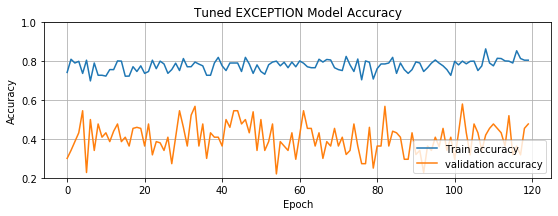

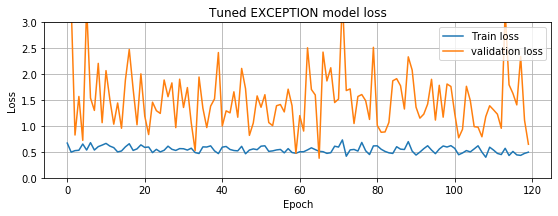

In [47]:
#PLOT FOR TUNED EXCEPTION MODEL
plt.figure(figsize=(20, 20))
plt.subplot(621)
plt.title("Tuned EXCEPTION Model Accuracy")
plt.plot(fin_mod2.history['accuracy'], label='Train accuracy')
plt.plot(fin_mod2.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
plt.grid(True)

plt.figure(figsize=(20, 20))
plt.subplot(622)
plt.title("Tuned EXCEPTION model loss")
plt.plot(fin_mod2.history['loss'], label='Train loss')
plt.plot(fin_mod2.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.legend(loc='upper right')
plt.grid(True)

#### Testing Model

In [49]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

model2.load_weights("best_model_2_task2.h5")

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=44,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model2.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 1s 19ms/step
Test loss: 1.6616244316101074
Test accuracy: 0.6388888955116272


## Lower Dimension Plot

In [78]:
from sklearn.manifold import TSNE

intermediate_layer_model_2 = models.Model(inputs=model2.input,
                                        outputs=model2.get_layer('dense_118').output)

tsne_eval_generator_2 = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")


logits_2 = intermediate_layer_model_2.predict_generator(tsne_eval_generator_2,verbose=1,steps = 270)

tsne_2 = TSNE(n_components=2, init='pca', random_state = 49) 
print(logits_2.shape)
tsne_obj_2 = tsne_2.fit_transform(logits_2)



Found 270 images belonging to 4 classes.
270/270 [==============================] - 6s 24ms/step
(270, 256)


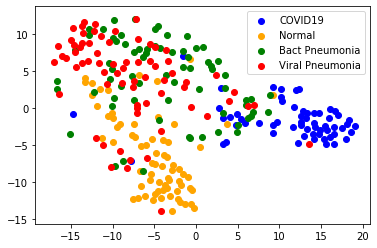

In [79]:
_x1=[]
_y1=[]

_x2=[]
_y2=[]

_x3=[]
_y3=[]

_x4=[]
_y4=[]


for i in range(tsne_obj_2.shape[0]):
    if(tsne_eval_generator_2.labels[i]==0):
        _x1.append(tsne_obj_2[i,0])
        _y1.append(tsne_obj_2[i,1])
    elif(tsne_eval_generator_2.labels[i]==1):
        _x2.append(tsne_obj_2[i,0])
        _y2.append(tsne_obj_2[i,1])
    elif(tsne_eval_generator_2.labels[i]==2):
        _x3.append(tsne_obj_2[i,0])
        _y3.append(tsne_obj_2[i,1])
    elif(tsne_eval_generator_2.labels[i]==3):
        _x4.append(tsne_obj_2[i,0])
        _y4.append(tsne_obj_2[i,1])

plt.scatter(_x1,_y1,c='blue',label = 'COVID19')
plt.scatter(_x2,_y2,c='orange',label = 'Normal')
plt.scatter(_x3,_y3,c='green',label = 'Bact Pneumonia')
plt.scatter(_x4,_y4,c='red',label = 'Viral Pneumonia')

plt.legend()

## Tuning my self created model


In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def build_own(activation,dropout,units):
    model_own = Sequential()
    model_own.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
    model_own.add(MaxPool2D(pool_size=(2,2)))
    model_own.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
    model_own.add(MaxPool2D(pool_size=(2,2)))
    model_own.add(Flatten())
    model_own.add(Dense(units = 128, activation= activation))
    model_own.add(Dropout(rate=  dropout))
    model_own.add(Dense(units = units, activation = activation))
    model_own.add(Dropout(rate= dropout))
    model_own.add(Dense(units=4, activation='softmax'))
    model_own.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),loss='categorical_crossentropy',metrics=["accuracy"])
    return model_own

param_5 = {'activation' : ['relu','sigmoid'],
        'dropout' : [0.15,0.20,0.25],
           'units': [32,64],
        'epochs' : [120]}

clf_3 = KerasClassifier(build_own)
X_train, y_train = train_batches.next()
X_val, y_val = valid_batches.next()
print(train_batches.class_indices)
print(valid_batches.class_indices)

grid_5 = GridSearchCV(estimator=clf_3, param_grid=param_5,verbose=1,cv=3)
grid_5.fit(X_train,y_train)

{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/120
6/6 [==============================] - 0s 43ms/step - loss: 1.4340 - accuracy: 0.0000e+00
Epoch 2/120
6/6 [==============================] - 0s 9ms/step - loss: 1.4575 - accuracy: 0.0000e+00
Epoch 3/120
6/6 [==============================] - 0s 9ms/step - loss: 1.2918 - accuracy: 0.1667
Epoch 4/120
6/6 [==============================] - 0s 9ms/step - loss: 1.1689 - accuracy: 0.3333
Epoch 5/120
6/6 [==============================] - 0s 9ms/step - loss: 1.3104 - accuracy: 0.5000
Epoch 6/120
6/6 [==============================] - 0s 9ms/step - loss: 0.9076 - accuracy: 0.8333
Epoch 7/120
6/6 [==============================] - 0s 9ms/step - loss: 0.9746 - accuracy: 0.5000
Epoch 8/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7768 - accuracy: 0.6667
Epoch 9/120
6/6 [==============================] - 0s 9ms/step - loss: 0.8558 - accuracy: 0.5000
Epoch 10/120
6/6 [==============================] - 0s 9ms/step - loss: 0.8131 - accuracy: 0.5000
Epoch 11/120
6/6 [==

Epoch 85/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 86/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0323 - accuracy: 1.0000
Epoch 87/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0349 - accuracy: 1.0000
Epoch 88/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 89/120
6/6 [==============================] - 0s 9ms/step - loss: 0.3022 - accuracy: 0.8333
Epoch 90/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0114 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 9ms/step - loss: 0.3722 - accuracy: 0.8333
Epoch 94/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 95/120
6/6 [==

Epoch 48/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0533 - accuracy: 1.0000
Epoch 49/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1112 - accuracy: 1.0000
Epoch 50/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0952 - accuracy: 1.0000
Epoch 51/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0159 - accuracy: 1.0000
Epoch 52/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1337 - accuracy: 1.0000
Epoch 53/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 54/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1116 - accuracy: 1.0000
Epoch 55/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0225 - accuracy: 1.0000
Epoch 56/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0284 - accuracy: 1.0000
Epoch 57/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0804 - accuracy: 1.0000
Epoch 58/120
7/7 [==

Epoch 11/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8634 - accuracy: 0.8571
Epoch 12/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5613 - accuracy: 0.8571
Epoch 13/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8176 - accuracy: 0.7143
Epoch 14/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5349 - accuracy: 0.8571
Epoch 15/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2887 - accuracy: 1.0000
Epoch 16/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5326 - accuracy: 0.8571
Epoch 17/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4426 - accuracy: 0.8571
Epoch 18/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3979 - accuracy: 0.8571
Epoch 19/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3872 - accuracy: 0.8571
Epoch 20/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5538 - accuracy: 0.7143
Epoch 21/120
7/7 [==

Epoch 95/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0095 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 8ms/step - loss: 4.3972e-04 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0111 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 99/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 100/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 101/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 102/120
7/7 [==============================] - 0s 8ms/step - loss: 5.3552e-04 - accuracy: 1.0000
Epoch 103/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 104/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 1

Epoch 58/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0596 - accuracy: 1.0000
Epoch 59/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0333 - accuracy: 1.0000
Epoch 60/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0109 - accuracy: 1.0000
Epoch 61/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0270 - accuracy: 1.0000
Epoch 62/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0108 - accuracy: 1.0000
Epoch 63/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0144 - accuracy: 1.0000
Epoch 64/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0264 - accuracy: 1.0000
Epoch 65/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 1.0000
Epoch 66/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 67/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0488 - accuracy: 1.0000
Epoch 68/120
6/6 [==

Epoch 21/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1822 - accuracy: 1.0000
Epoch 22/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1293 - accuracy: 1.0000
Epoch 23/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1365 - accuracy: 1.0000
Epoch 24/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1119 - accuracy: 1.0000
Epoch 25/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4966 - accuracy: 0.8571
Epoch 26/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1298 - accuracy: 1.0000
Epoch 27/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0745 - accuracy: 1.0000
Epoch 28/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 1.0000
Epoch 29/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1871 - accuracy: 1.0000
Epoch 30/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1168 - accuracy: 1.0000
Epoch 31/120
7/7 [==

Epoch 105/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0232 - accuracy: 1.0000
Epoch 106/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 107/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 108/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 109/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 110/120
7/7 [==============================] - 0s 8ms/step - loss: 9.6586e-04 - accuracy: 1.0000
Epoch 111/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 112/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0139 - accuracy: 1.0000
Epoch 113/120
7/7 [==============================] - 0s 8ms/step - loss: 3.8274e-04 - accuracy: 1.0000
Epoch 114/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0038 - accuracy: 1.0000
Ep

Epoch 68/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 69/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0229 - accuracy: 1.0000
Epoch 70/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0205 - accuracy: 1.0000
Epoch 71/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 72/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 73/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 74/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 75/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 76/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 77/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 78/120
7/7 [==

Epoch 31/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0558 - accuracy: 1.0000
Epoch 32/120
6/6 [==============================] - 0s 9ms/step - loss: 0.2878 - accuracy: 1.0000
Epoch 33/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0982 - accuracy: 1.0000
Epoch 34/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0491 - accuracy: 1.0000
Epoch 35/120
6/6 [==============================] - 0s 9ms/step - loss: 0.1461 - accuracy: 1.0000
Epoch 36/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0446 - accuracy: 1.0000
Epoch 37/120
6/6 [==============================] - 0s 9ms/step - loss: 0.1087 - accuracy: 1.0000
Epoch 38/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0738 - accuracy: 1.0000
Epoch 39/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5099 - accuracy: 0.6667
Epoch 40/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 1.0000
Epoch 41/120
6/6 [==

Epoch 115/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 116/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 117/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0255 - accuracy: 1.0000
Epoch 118/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0287 - accuracy: 1.0000
Epoch 119/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0463 - accuracy: 1.0000
Epoch 120/120
4/4 [==============================] - 0s 14ms/step
Epoch 1/120
7/7 [==============================] - 0s 38ms/step - loss: 1.4354 - accuracy: 0.1429
Epoch 2/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2900 - accuracy: 0.1429
Epoch 3/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2266 - accuracy: 0.4286
Epoch 4/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0643 - accuracy: 0.4286
Epoch 5/120
7/7 [==============================] -

7/7 [==============================] - 0s 8ms/step - loss: 0.0635 - accuracy: 1.0000
Epoch 79/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0541 - accuracy: 1.0000
Epoch 80/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1450 - accuracy: 1.0000
Epoch 81/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 82/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0600 - accuracy: 1.0000
Epoch 83/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0125 - accuracy: 1.0000
Epoch 84/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0157 - accuracy: 1.0000
Epoch 85/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0884 - accuracy: 1.0000
Epoch 86/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0237 - accuracy: 1.0000
Epoch 88/120
7/7 [===============

Epoch 41/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1890 - accuracy: 0.8571
Epoch 42/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0987 - accuracy: 1.0000
Epoch 43/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0865 - accuracy: 1.0000
Epoch 44/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2064 - accuracy: 1.0000
Epoch 45/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1036 - accuracy: 1.0000
Epoch 46/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3010 - accuracy: 0.8571
Epoch 47/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0343 - accuracy: 1.0000
Epoch 48/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1140 - accuracy: 1.0000
Epoch 49/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0235 - accuracy: 1.0000
Epoch 50/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1497 - accuracy: 1.0000
Epoch 51/120
7/7 [==

Epoch 4/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7789 - accuracy: 0.6667
Epoch 5/120
6/6 [==============================] - 0s 9ms/step - loss: 1.2639 - accuracy: 0.3333
Epoch 6/120
6/6 [==============================] - 0s 9ms/step - loss: 0.9019 - accuracy: 0.5000
Epoch 7/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4921 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 9ms/step - loss: 0.8644 - accuracy: 0.5000
Epoch 9/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7806 - accuracy: 0.5000
Epoch 10/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6286 - accuracy: 0.5000
Epoch 11/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4117 - accuracy: 0.8333
Epoch 12/120
6/6 [==============================] - 0s 9ms/step - loss: 0.2845 - accuracy: 0.8333
Epoch 13/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4321 - accuracy: 0.8333
Epoch 14/120
6/6 [========

Epoch 88/120
6/6 [==============================] - 0s 9ms/step - loss: 1.4109e-04 - accuracy: 1.0000
Epoch 89/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 90/120
6/6 [==============================] - 0s 9ms/step - loss: 4.8230e-04 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 9ms/step - loss: 9.9880e-04 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 95/120
6/6 [==============================] - 0s 9ms/step - loss: 1.4186e-04 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 97/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0293 - accuracy: 1.0000
Epoc

Epoch 51/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0123 - accuracy: 1.0000
Epoch 52/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0817 - accuracy: 1.0000
Epoch 53/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0316 - accuracy: 1.0000
Epoch 54/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0865 - accuracy: 1.0000
Epoch 55/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0307 - accuracy: 1.0000
Epoch 56/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0138 - accuracy: 1.0000
Epoch 57/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0127 - accuracy: 1.0000
Epoch 58/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0456 - accuracy: 1.0000
Epoch 59/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0424 - accuracy: 1.0000
Epoch 60/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0317 - accuracy: 1.0000
Epoch 61/120
7/7 [==

Epoch 14/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0629 - accuracy: 0.5714
Epoch 15/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5849 - accuracy: 0.8571
Epoch 16/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4472 - accuracy: 0.7143
Epoch 17/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3879 - accuracy: 0.8571
Epoch 18/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4532 - accuracy: 0.7143
Epoch 19/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4660 - accuracy: 0.8571
Epoch 20/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1669 - accuracy: 1.0000
Epoch 21/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1492 - accuracy: 1.0000
Epoch 22/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2321 - accuracy: 1.0000
Epoch 23/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1316 - accuracy: 1.0000
Epoch 24/120
7/7 [==

Epoch 98/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 99/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 100/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0471 - accuracy: 1.0000
Epoch 101/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 102/120
7/7 [==============================] - 0s 8ms/step - loss: 6.6294e-04 - accuracy: 1.0000
Epoch 103/120
7/7 [==============================] - 0s 8ms/step - loss: 4.4447e-04 - accuracy: 1.0000
Epoch 104/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 105/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 106/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 107/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0043 - accuracy: 1.0000
Epoc

Epoch 61/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0716 - accuracy: 1.0000
Epoch 62/120
6/6 [==============================] - 0s 9ms/step - loss: 0.2055 - accuracy: 1.0000
Epoch 63/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0243 - accuracy: 1.0000
Epoch 64/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0630 - accuracy: 1.0000
Epoch 65/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0487 - accuracy: 1.0000
Epoch 66/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0734 - accuracy: 1.0000
Epoch 67/120
6/6 [==============================] - 0s 9ms/step - loss: 0.1267 - accuracy: 1.0000
Epoch 68/120
6/6 [==============================] - 0s 9ms/step - loss: 0.1768 - accuracy: 0.8333
Epoch 69/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0272 - accuracy: 1.0000
Epoch 70/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 71/120
6/6 [==

Epoch 24/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6870 - accuracy: 0.5714
Epoch 25/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6170 - accuracy: 0.7143
Epoch 26/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6064 - accuracy: 0.8571
Epoch 27/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6027 - accuracy: 0.7143
Epoch 28/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5829 - accuracy: 0.7143
Epoch 29/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4721 - accuracy: 0.8571
Epoch 30/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5193 - accuracy: 1.0000
Epoch 31/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4790 - accuracy: 0.7143
Epoch 32/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3510 - accuracy: 1.0000
Epoch 33/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4700 - accuracy: 0.7143
Epoch 34/120
7/7 [==

Epoch 108/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0167 - accuracy: 1.0000
Epoch 109/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2966 - accuracy: 0.8571
Epoch 110/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0611 - accuracy: 1.0000
Epoch 111/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0413 - accuracy: 1.0000
Epoch 112/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1915 - accuracy: 1.0000
Epoch 113/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1477 - accuracy: 1.0000
Epoch 114/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0374 - accuracy: 1.0000
Epoch 115/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1689 - accuracy: 1.0000
Epoch 116/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3501 - accuracy: 0.7143
Epoch 117/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0928 - accuracy: 1.0000
Epoch 118/

7/7 [==============================] - 0s 8ms/step - loss: 0.0281 - accuracy: 1.0000
Epoch 72/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0876 - accuracy: 1.0000
Epoch 73/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 74/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0124 - accuracy: 1.0000
Epoch 75/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0105 - accuracy: 1.0000
Epoch 76/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0646 - accuracy: 1.0000
Epoch 77/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0248 - accuracy: 1.0000
Epoch 78/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1523 - accuracy: 0.8571
Epoch 79/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0345 - accuracy: 1.0000
Epoch 80/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0173 - accuracy: 1.0000
Epoch 81/120
7/7 [===============

6/6 [==============================] - 0s 9ms/step - loss: 0.0876 - accuracy: 1.0000
Epoch 35/120
6/6 [==============================] - 0s 9ms/step - loss: 0.1096 - accuracy: 1.0000
Epoch 36/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0551 - accuracy: 1.0000
Epoch 37/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0772 - accuracy: 1.0000
Epoch 38/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0339 - accuracy: 1.0000
Epoch 39/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0280 - accuracy: 1.0000
Epoch 40/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0619 - accuracy: 1.0000
Epoch 41/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0475 - accuracy: 1.0000
Epoch 42/120
6/6 [==============================] - 0s 9ms/step - loss: 0.3247 - accuracy: 0.8333
Epoch 43/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0754 - accuracy: 1.0000
Epoch 44/120
6/6 [===============

Epoch 118/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0534 - accuracy: 1.0000
Epoch 119/120
6/6 [==============================] - 0s 9ms/step - loss: 7.9838e-04 - accuracy: 1.0000
Epoch 120/120
4/4 [==============================] - 0s 14ms/step
Epoch 1/120
7/7 [==============================] - 0s 37ms/step - loss: 1.3694 - accuracy: 0.1429
Epoch 2/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2330 - accuracy: 0.4286
Epoch 3/120
7/7 [==============================] - 0s 8ms/step - loss: 1.7599 - accuracy: 0.2857
Epoch 4/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8915 - accuracy: 0.5714
Epoch 5/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3785 - accuracy: 0.4286
Epoch 6/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1904 - accuracy: 0.5714
Epoch 7/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0184 - accuracy: 0.7143
Epoch 8/120
7/7 [==============================] - 0

7/7 [==============================] - 0s 8ms/step - loss: 0.1159 - accuracy: 1.0000
Epoch 82/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0757 - accuracy: 1.0000
Epoch 83/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0805 - accuracy: 1.0000
Epoch 84/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0166 - accuracy: 1.0000
Epoch 85/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0315 - accuracy: 1.0000
Epoch 86/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0269 - accuracy: 1.0000
Epoch 88/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0962 - accuracy: 1.0000
Epoch 89/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0425 - accuracy: 1.0000
Epoch 90/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1878 - accuracy: 0.8571
Epoch 91/120
7/7 [===============

Epoch 44/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3317 - accuracy: 0.8571
Epoch 45/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2237 - accuracy: 0.8571
Epoch 46/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1926 - accuracy: 0.8571
Epoch 47/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2479 - accuracy: 0.8571
Epoch 48/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0295 - accuracy: 1.0000
Epoch 49/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0635 - accuracy: 1.0000
Epoch 50/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0919 - accuracy: 1.0000
Epoch 51/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2109 - accuracy: 1.0000
Epoch 52/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3035 - accuracy: 0.8571
Epoch 53/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3526 - accuracy: 0.8571
Epoch 54/120
7/7 [==

Epoch 7/120
6/6 [==============================] - 0s 9ms/step - loss: 1.1778 - accuracy: 0.3333
Epoch 8/120
6/6 [==============================] - 0s 9ms/step - loss: 1.2349 - accuracy: 0.3333
Epoch 9/120
6/6 [==============================] - 0s 9ms/step - loss: 1.1989 - accuracy: 0.1667
Epoch 10/120
6/6 [==============================] - 0s 9ms/step - loss: 1.0895 - accuracy: 0.5000
Epoch 11/120
6/6 [==============================] - 0s 9ms/step - loss: 1.1362 - accuracy: 0.3333
Epoch 12/120
6/6 [==============================] - 0s 9ms/step - loss: 1.2283 - accuracy: 0.1667
Epoch 13/120
6/6 [==============================] - 0s 9ms/step - loss: 1.0738 - accuracy: 0.5000
Epoch 14/120
6/6 [==============================] - 0s 9ms/step - loss: 1.0554 - accuracy: 0.3333
Epoch 15/120
6/6 [==============================] - 0s 9ms/step - loss: 0.9983 - accuracy: 0.6667
Epoch 16/120
6/6 [==============================] - 0s 9ms/step - loss: 1.0442 - accuracy: 0.3333
Epoch 17/120
6/6 [=====

Epoch 91/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5604 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7290 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6959 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7029 - accuracy: 0.8333
Epoch 95/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5675 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6220 - accuracy: 1.0000
Epoch 97/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6096 - accuracy: 1.0000
Epoch 98/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6466 - accuracy: 0.8333
Epoch 99/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7025 - accuracy: 1.0000
Epoch 100/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6329 - accuracy: 0.8333
Epoch 101/120
6/6 [

Epoch 54/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7048 - accuracy: 1.0000
Epoch 55/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6263 - accuracy: 1.0000
Epoch 56/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8144 - accuracy: 0.8571
Epoch 57/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7902 - accuracy: 1.0000
Epoch 58/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8091 - accuracy: 1.0000
Epoch 59/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7687 - accuracy: 1.0000
Epoch 60/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7681 - accuracy: 0.8571
Epoch 61/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8014 - accuracy: 0.7143
Epoch 62/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6172 - accuracy: 1.0000
Epoch 63/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6280 - accuracy: 1.0000
Epoch 64/120
7/7 [==

Epoch 17/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1145 - accuracy: 0.7143
Epoch 18/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9674 - accuracy: 0.8571
Epoch 19/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9306 - accuracy: 0.8571
Epoch 20/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8704 - accuracy: 0.7143
Epoch 21/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1118 - accuracy: 0.5714
Epoch 22/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8814 - accuracy: 0.7143
Epoch 23/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8688 - accuracy: 0.5714
Epoch 24/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0594 - accuracy: 0.5714
Epoch 25/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9651 - accuracy: 0.4286
Epoch 26/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8488 - accuracy: 0.7143
Epoch 27/120
7/7 [==

Epoch 101/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7141 - accuracy: 1.0000
Epoch 102/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5869 - accuracy: 0.8571
Epoch 103/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6710 - accuracy: 1.0000
Epoch 104/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5681 - accuracy: 1.0000
Epoch 105/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7318 - accuracy: 1.0000
Epoch 106/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5805 - accuracy: 1.0000
Epoch 107/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6845 - accuracy: 0.8571
Epoch 108/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7693 - accuracy: 0.8571
Epoch 109/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5290 - accuracy: 1.0000
Epoch 110/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6161 - accuracy: 1.0000
Epoch 111/

Epoch 64/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6013 - accuracy: 1.0000
Epoch 65/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7235 - accuracy: 1.0000
Epoch 66/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5810 - accuracy: 1.0000
Epoch 67/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5467 - accuracy: 1.0000
Epoch 68/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6326 - accuracy: 1.0000
Epoch 69/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6556 - accuracy: 1.0000
Epoch 70/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7021 - accuracy: 1.0000
Epoch 71/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5061 - accuracy: 1.0000
Epoch 72/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6298 - accuracy: 1.0000
Epoch 73/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6247 - accuracy: 1.0000
Epoch 74/120
6/6 [==

Epoch 27/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1028 - accuracy: 0.4286
Epoch 28/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0074 - accuracy: 0.7143
Epoch 29/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1041 - accuracy: 0.5714
Epoch 30/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2256 - accuracy: 0.2857
Epoch 31/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2420 - accuracy: 0.5714
Epoch 32/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0637 - accuracy: 0.2857
Epoch 33/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1981 - accuracy: 0.2857
Epoch 34/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1209 - accuracy: 0.2857
Epoch 35/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9198 - accuracy: 0.7143
Epoch 36/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1156 - accuracy: 0.2857
Epoch 37/120
7/7 [==

Epoch 111/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8268 - accuracy: 1.0000
Epoch 112/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7611 - accuracy: 1.0000
Epoch 113/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7321 - accuracy: 1.0000
Epoch 114/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8369 - accuracy: 0.7143
Epoch 115/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7330 - accuracy: 1.0000
Epoch 116/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6768 - accuracy: 1.0000
Epoch 117/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7318 - accuracy: 0.8571
Epoch 118/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7692 - accuracy: 0.8571
Epoch 119/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8217 - accuracy: 0.8571
Epoch 120/120
3/3 [==============================] - 0s 18ms/step
Epoch 1/120
7/7 [==========================

7/7 [==============================] - 0s 8ms/step - loss: 0.2885 - accuracy: 1.0000
Epoch 75/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2612 - accuracy: 1.0000
Epoch 76/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3689 - accuracy: 1.0000
Epoch 77/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2842 - accuracy: 1.0000
Epoch 78/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2761 - accuracy: 1.0000
Epoch 79/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3186 - accuracy: 1.0000
Epoch 80/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3248 - accuracy: 1.0000
Epoch 81/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3005 - accuracy: 1.0000
Epoch 82/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2447 - accuracy: 1.0000
Epoch 83/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3170 - accuracy: 1.0000
Epoch 84/120
7/7 [===============

6/6 [==============================] - 0s 9ms/step - loss: 0.5795 - accuracy: 1.0000
Epoch 38/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4919 - accuracy: 1.0000
Epoch 39/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6446 - accuracy: 1.0000
Epoch 40/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6045 - accuracy: 1.0000
Epoch 41/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5776 - accuracy: 0.8333
Epoch 42/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4494 - accuracy: 1.0000
Epoch 43/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5198 - accuracy: 1.0000
Epoch 44/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5217 - accuracy: 1.0000
Epoch 45/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5240 - accuracy: 1.0000
Epoch 46/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5813 - accuracy: 1.0000
Epoch 47/120
6/6 [===============

4/4 [==============================] - 0s 14ms/step
Epoch 1/120
7/7 [==============================] - 0s 38ms/step - loss: 2.1025 - accuracy: 0.1429
Epoch 2/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3597 - accuracy: 0.2857
Epoch 3/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3547 - accuracy: 0.2857
Epoch 4/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2297 - accuracy: 0.5714
Epoch 5/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2552 - accuracy: 0.5714
Epoch 6/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2706 - accuracy: 0.2857
Epoch 7/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2222 - accuracy: 0.7143
Epoch 8/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2036 - accuracy: 0.5714
Epoch 9/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2633 - accuracy: 0.4286
Epoch 10/120
7/7 [==============================] - 0s 8ms/step - loss: 1.

Epoch 85/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6798 - accuracy: 1.0000
Epoch 86/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6108 - accuracy: 1.0000
Epoch 87/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7026 - accuracy: 0.8571
Epoch 88/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6241 - accuracy: 0.8571
Epoch 89/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7462 - accuracy: 0.8571
Epoch 90/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5970 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8386 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7038 - accuracy: 0.8571
Epoch 93/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7706 - accuracy: 0.8571
Epoch 94/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7955 - accuracy: 0.8571
Epoch 95/120
7/7 [==

Epoch 48/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6063 - accuracy: 1.0000
Epoch 49/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5906 - accuracy: 1.0000
Epoch 50/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5634 - accuracy: 0.8571
Epoch 51/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4651 - accuracy: 1.0000
Epoch 52/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4910 - accuracy: 1.0000
Epoch 53/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5409 - accuracy: 1.0000
Epoch 54/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5437 - accuracy: 0.8571
Epoch 55/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4986 - accuracy: 1.0000
Epoch 56/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5195 - accuracy: 0.8571
Epoch 57/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4949 - accuracy: 1.0000
Epoch 58/120
7/7 [==

Epoch 11/120
6/6 [==============================] - 0s 9ms/step - loss: 1.3881 - accuracy: 0.1667
Epoch 12/120
6/6 [==============================] - 0s 9ms/step - loss: 1.1885 - accuracy: 0.3333
Epoch 13/120
6/6 [==============================] - 0s 9ms/step - loss: 1.1384 - accuracy: 0.1667
Epoch 14/120
6/6 [==============================] - 0s 9ms/step - loss: 1.2857 - accuracy: 0.5000
Epoch 15/120
6/6 [==============================] - 0s 9ms/step - loss: 1.2132 - accuracy: 0.3333
Epoch 16/120
6/6 [==============================] - 0s 9ms/step - loss: 1.2582 - accuracy: 0.3333
Epoch 17/120
6/6 [==============================] - 0s 9ms/step - loss: 1.3338 - accuracy: 0.5000
Epoch 18/120
6/6 [==============================] - 0s 9ms/step - loss: 1.4242 - accuracy: 0.3333
Epoch 19/120
6/6 [==============================] - 0s 9ms/step - loss: 1.0431 - accuracy: 0.5000
Epoch 20/120
6/6 [==============================] - 0s 9ms/step - loss: 1.0271 - accuracy: 0.5000
Epoch 21/120
6/6 [==

Epoch 95/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6916 - accuracy: 1.0000
Epoch 96/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5905 - accuracy: 0.8333
Epoch 97/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5695 - accuracy: 1.0000
Epoch 98/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7646 - accuracy: 0.8333
Epoch 99/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7731 - accuracy: 0.6667
Epoch 100/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6572 - accuracy: 0.8333
Epoch 101/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7095 - accuracy: 1.0000
Epoch 102/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6598 - accuracy: 1.0000
Epoch 103/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7108 - accuracy: 1.0000
Epoch 104/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7725 - accuracy: 0.8333
Epoch 105/120
6

Epoch 58/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7216 - accuracy: 0.7143
Epoch 59/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5445 - accuracy: 1.0000
Epoch 60/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5685 - accuracy: 1.0000
Epoch 61/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6153 - accuracy: 1.0000
Epoch 62/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5329 - accuracy: 1.0000
Epoch 63/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4897 - accuracy: 1.0000
Epoch 64/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6217 - accuracy: 1.0000
Epoch 65/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4972 - accuracy: 0.8571
Epoch 66/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4222 - accuracy: 1.0000
Epoch 67/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5107 - accuracy: 1.0000
Epoch 68/120
7/7 [==

Epoch 21/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3212 - accuracy: 0.2857
Epoch 22/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3415 - accuracy: 0.1429
Epoch 23/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3074 - accuracy: 0.2857
Epoch 24/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2281 - accuracy: 0.2857
Epoch 25/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0555 - accuracy: 0.4286
Epoch 26/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9528 - accuracy: 0.5714
Epoch 27/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2986 - accuracy: 0.2857
Epoch 28/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9448 - accuracy: 0.8571
Epoch 29/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2537 - accuracy: 0.5714
Epoch 30/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1217 - accuracy: 0.5714
Epoch 31/120
7/7 [==

Epoch 105/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8128 - accuracy: 0.7143
Epoch 106/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9350 - accuracy: 0.5714
Epoch 107/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7708 - accuracy: 0.8571
Epoch 108/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7291 - accuracy: 0.8571
Epoch 109/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8219 - accuracy: 0.7143
Epoch 110/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8042 - accuracy: 1.0000
Epoch 111/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7838 - accuracy: 1.0000
Epoch 112/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7345 - accuracy: 1.0000
Epoch 113/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7435 - accuracy: 0.8571
Epoch 114/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7409 - accuracy: 1.0000
Epoch 115/

Epoch 68/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4551 - accuracy: 1.0000
Epoch 69/120
6/6 [==============================] - 0s 9ms/step - loss: 0.3221 - accuracy: 1.0000
Epoch 70/120
6/6 [==============================] - 0s 9ms/step - loss: 0.3931 - accuracy: 1.0000
Epoch 71/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5370 - accuracy: 1.0000
Epoch 72/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4396 - accuracy: 1.0000
Epoch 73/120
6/6 [==============================] - 0s 9ms/step - loss: 0.2763 - accuracy: 1.0000
Epoch 74/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4944 - accuracy: 1.0000
Epoch 75/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4069 - accuracy: 1.0000
Epoch 76/120
6/6 [==============================] - 0s 9ms/step - loss: 0.3654 - accuracy: 1.0000
Epoch 77/120
6/6 [==============================] - 0s 9ms/step - loss: 0.3459 - accuracy: 1.0000
Epoch 78/120
6/6 [==

Epoch 31/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2228 - accuracy: 0.4286
Epoch 32/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1228 - accuracy: 0.4286
Epoch 33/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9798 - accuracy: 0.5714
Epoch 34/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2962 - accuracy: 0.4286
Epoch 35/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9646 - accuracy: 0.7143
Epoch 36/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0256 - accuracy: 0.5714
Epoch 37/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8880 - accuracy: 0.7143
Epoch 38/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3521 - accuracy: 0.5714
Epoch 39/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1717 - accuracy: 0.4286
Epoch 40/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2295 - accuracy: 0.5714
Epoch 41/120
7/7 [==

Epoch 115/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9304 - accuracy: 1.0000
Epoch 116/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6953 - accuracy: 1.0000
Epoch 117/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6890 - accuracy: 0.8571
Epoch 118/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9475 - accuracy: 0.7143
Epoch 119/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8775 - accuracy: 0.7143
Epoch 120/120
3/3 [==============================] - 0s 19ms/step
Epoch 1/120
7/7 [==============================] - 0s 37ms/step - loss: 1.8562 - accuracy: 0.0000e+00
Epoch 2/120
7/7 [==============================] - 0s 8ms/step - loss: 1.4049 - accuracy: 0.2857
Epoch 3/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3615 - accuracy: 0.2857
Epoch 4/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3382 - accuracy: 0.2857
Epoch 5/120
7/7 [=============================

7/7 [==============================] - 0s 8ms/step - loss: 0.7361 - accuracy: 0.8571
Epoch 79/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8412 - accuracy: 0.8571
Epoch 80/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5548 - accuracy: 1.0000
Epoch 81/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6573 - accuracy: 0.8571
Epoch 82/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5744 - accuracy: 1.0000
Epoch 83/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5228 - accuracy: 1.0000
Epoch 84/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6497 - accuracy: 1.0000
Epoch 85/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4834 - accuracy: 1.0000
Epoch 86/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7205 - accuracy: 0.8571
Epoch 87/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7424 - accuracy: 0.8571
Epoch 88/120
7/7 [===============

6/6 [==============================] - 0s 9ms/step - loss: 0.7797 - accuracy: 0.8333
Epoch 42/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4613 - accuracy: 1.0000
Epoch 43/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5035 - accuracy: 1.0000
Epoch 44/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5888 - accuracy: 1.0000
Epoch 45/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7502 - accuracy: 0.8333
Epoch 46/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6453 - accuracy: 1.0000
Epoch 47/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4816 - accuracy: 1.0000
Epoch 48/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6016 - accuracy: 1.0000
Epoch 49/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6312 - accuracy: 1.0000
Epoch 50/120
6/6 [==============================] - 0s 9ms/step - loss: 0.4672 - accuracy: 1.0000
Epoch 51/120
6/6 [===============

Epoch 4/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0937 - accuracy: 0.4286
Epoch 5/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1672 - accuracy: 0.1429
Epoch 6/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1258 - accuracy: 0.5714
Epoch 7/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1226 - accuracy: 0.4286
Epoch 8/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0451 - accuracy: 0.5714
Epoch 9/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0582 - accuracy: 0.5714
Epoch 10/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2520 - accuracy: 0.1429
Epoch 11/120
7/7 [==============================] - 0s 8ms/step - loss: 1.1005 - accuracy: 0.2857
Epoch 12/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9734 - accuracy: 0.5714
Epoch 13/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0126 - accuracy: 0.5714
Epoch 14/120
7/7 [========

Epoch 88/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5734 - accuracy: 0.8571
Epoch 89/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5704 - accuracy: 0.8571
Epoch 90/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5430 - accuracy: 1.0000
Epoch 91/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4370 - accuracy: 1.0000
Epoch 92/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3807 - accuracy: 1.0000
Epoch 93/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6161 - accuracy: 0.8571
Epoch 94/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5336 - accuracy: 0.8571
Epoch 95/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4529 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5930 - accuracy: 0.8571
Epoch 97/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4779 - accuracy: 1.0000
Epoch 98/120
7/7 [==

Epoch 51/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9808 - accuracy: 0.7143
Epoch 52/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8148 - accuracy: 1.0000
Epoch 53/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9567 - accuracy: 0.5714
Epoch 54/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7544 - accuracy: 0.8571
Epoch 55/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8670 - accuracy: 0.7143
Epoch 56/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7624 - accuracy: 1.0000
Epoch 57/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8119 - accuracy: 1.0000
Epoch 58/120
7/7 [==============================] - 0s 8ms/step - loss: 0.9562 - accuracy: 0.8571
Epoch 59/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7894 - accuracy: 1.0000
Epoch 60/120
7/7 [==============================] - 0s 8ms/step - loss: 0.8110 - accuracy: 0.8571
Epoch 61/120
7/7 [==

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  5.0min finished
/share/pkg.7/python3/3.6.9/install/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/120
10/10 [==============================] - 0s 27ms/step - loss: 1.3701 - accuracy: 0.4000
Epoch 2/120
10/10 [==============================] - 0s 7ms/step - loss: 1.2932 - accuracy: 0.4000
Epoch 3/120
10/10 [==============================] - 0s 7ms/step - loss: 1.0153 - accuracy: 0.5000
Epoch 4/120
10/10 [==============================] - 0s 7ms/step - loss: 1.0212 - accuracy: 0.5000
Epoch 5/120
10/10 [==============================] - 0s 7ms/step - loss: 0.8414 - accuracy: 0.5000
Epoch 6/120
10/10 [==============================] - 0s 7ms/step - loss: 0.8177 - accuracy: 0.6000
Epoch 7/120
10/10 [==============================] - 0s 7ms/step - loss: 0.9113 - accuracy: 0.7000
Epoch 8/120
10/10 [==============================] - 0s 7ms/step - loss: 0.7532 - accuracy: 0.8000
Epoch 9/120
10/10 [==============================] - 0s 7ms/step - loss: 0.4170 - accuracy: 0.9000
Epoch 10/120
10/10 [==============================] - 0s 7ms/step - loss: 0.5397 - accuracy: 0.7000
Epoch 11

10/10 [==============================] - 0s 7ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 84/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 85/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0731 - accuracy: 0.9000
Epoch 86/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 1.0000
Epoch 87/120
10/10 [==============================] - 0s 7ms/step - loss: 0.2012 - accuracy: 0.9000
Epoch 88/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 89/120
10/10 [==============================] - 0s 7ms/step - loss: 0.2589 - accuracy: 0.9000
Epoch 90/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0125 - accuracy: 1.0000
Epoch 91/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 92/120
10/10 [==============================] - 0s 7ms/step - loss: 0.1161 - accuracy: 0.9000
Epoch 93/120


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x2b5eac7d8f60>,
             iid='warn', n_jobs=None,
             param_grid={'activation': ['relu', 'sigmoid'],
                         'dropout': [0.15, 0.2, 0.25], 'epochs': [120],
                         'units': [32, 64]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [19]:
print(grid_5.best_params_)

{'activation': 'relu', 'dropout': 0.15, 'epochs': 120, 'units': 32}


In [22]:
def build_estimator_own(learning_rate):
    est_own = Sequential()
    est_own.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
    est_own.add(MaxPool2D(pool_size=(2,2)))
    est_own.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
    est_own.add(MaxPool2D(pool_size=(2,2)))
    est_own.add(Flatten())
    est_own.add(Dense(units = 128, activation= 'relu'))
    est_own.add(Dropout(rate=  0.15))
    est_own.add(Dense(units = 32, activation = 'relu'))
    est_own.add(Dropout(rate= 0.15))
    est_own.add(Dense(units=4, activation='softmax'))
    est_own.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
    return est_own


param_6 = {'learning_rate' : [0.0001,0.001,0.01],
         'epochs' : [120]}

est_own = KerasClassifier(build_estimator_own)
# X_train, y_train = train_batches.next()
# X_val, y_val = valid_batches.next()
print(train_batches.class_indices)
print(valid_batches.class_indices)

grid_6 = GridSearchCV(estimator=est_own, param_grid=param_6 ,verbose=1,cv=3)
grid_6.fit(X_train,y_train)

{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/120
6/6 [==============================] - 0s 47ms/step - loss: 1.4220 - accuracy: 0.1667
Epoch 2/120
6/6 [==============================] - 0s 9ms/step - loss: 1.1558 - accuracy: 0.1667
Epoch 3/120
6/6 [==============================] - 0s 9ms/step - loss: 0.9458 - accuracy: 0.5000
Epoch 4/120
6/6 [==============================] - 0s 9ms/step - loss: 1.0785 - accuracy: 0.3333
Epoch 5/120
6/6 [==============================] - 0s 9ms/step - loss: 0.6246 - accuracy: 0.8333
Epoch 6/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7326 - accuracy: 0.6667
Epoch 7/120
6/6 [==============================] - 0s 9ms/step - loss: 0.5559 - accuracy: 1.0000
Epoch 8/120
6/6 [==============================] - 0s 9ms/step - loss: 0.8129 - accuracy: 0.5000
Epoch 9/120
6/6 [==============================] - 0s 9ms/step - loss: 1.2229 - accuracy: 0.5000
Epoch 10/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7975 - accuracy: 0.6667
Epoch 11/120
6/6 [==========

Epoch 85/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 86/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0552 - accuracy: 1.0000
Epoch 87/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0122 - accuracy: 1.0000
Epoch 88/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0136 - accuracy: 1.0000
Epoch 89/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 90/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0691 - accuracy: 1.0000
Epoch 91/120
6/6 [==============================] - 0s 9ms/step - loss: 7.5328e-04 - accuracy: 1.0000
Epoch 92/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 93/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0684 - accuracy: 1.0000
Epoch 94/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0129 - accuracy: 1.0000
Epoch 95/120
6/6

Epoch 48/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1124 - accuracy: 1.0000
Epoch 49/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1088 - accuracy: 1.0000
Epoch 50/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0914 - accuracy: 1.0000
Epoch 51/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3106 - accuracy: 0.8571
Epoch 52/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0224 - accuracy: 1.0000
Epoch 53/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1125 - accuracy: 1.0000
Epoch 54/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1360 - accuracy: 1.0000
Epoch 55/120
7/7 [==============================] - 0s 8ms/step - loss: 0.1879 - accuracy: 1.0000
Epoch 56/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0676 - accuracy: 1.0000
Epoch 57/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0780 - accuracy: 1.0000
Epoch 58/120
7/7 [==

Epoch 11/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6649 - accuracy: 0.8571
Epoch 12/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5069 - accuracy: 0.7143
Epoch 13/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4329 - accuracy: 0.7143
Epoch 14/120
7/7 [==============================] - 0s 8ms/step - loss: 0.5579 - accuracy: 0.7143
Epoch 15/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4891 - accuracy: 0.8571
Epoch 16/120
7/7 [==============================] - 0s 8ms/step - loss: 0.2696 - accuracy: 1.0000
Epoch 17/120
7/7 [==============================] - 0s 8ms/step - loss: 0.4480 - accuracy: 0.8571
Epoch 18/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7618 - accuracy: 0.5714
Epoch 19/120
7/7 [==============================] - 0s 8ms/step - loss: 0.7670 - accuracy: 0.8571
Epoch 20/120
7/7 [==============================] - 0s 8ms/step - loss: 0.6678 - accuracy: 0.7143
Epoch 21/120
7/7 [==

7/7 [==============================] - 0s 8ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 95/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 96/120
7/7 [==============================] - 0s 8ms/step - loss: 4.6760e-04 - accuracy: 1.0000
Epoch 97/120
7/7 [==============================] - 0s 8ms/step - loss: 3.5294e-04 - accuracy: 1.0000
Epoch 98/120
7/7 [==============================] - 0s 8ms/step - loss: 2.1896e-04 - accuracy: 1.0000
Epoch 99/120
7/7 [==============================] - 0s 8ms/step - loss: 1.7491e-04 - accuracy: 1.0000
Epoch 100/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 101/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 102/120
7/7 [==============================] - 0s 8ms/step - loss: 8.1722e-04 - accuracy: 1.0000
Epoch 103/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0397 - accuracy: 1.0000
Epoch 104

Epoch 57/120
6/6 [==============================] - 0s 9ms/step - loss: 3.0719e-04 - accuracy: 1.0000
Epoch 58/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 59/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0524 - accuracy: 1.0000
Epoch 60/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0574 - accuracy: 1.0000
Epoch 61/120
6/6 [==============================] - 0s 9ms/step - loss: 4.8654e-05 - accuracy: 1.0000
Epoch 62/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 63/120
6/6 [==============================] - 0s 9ms/step - loss: 2.6374e-04 - accuracy: 1.0000
Epoch 64/120
6/6 [==============================] - 0s 9ms/step - loss: 7.6607e-05 - accuracy: 1.0000
Epoch 65/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0334 - accuracy: 1.0000
Epoch 66/120
6/6 [==============================] - 0s 9ms/step - loss: 5.5432e-06 - accuracy: 1.0000


Epoch 18/120
7/7 [==============================] - 0s 8ms/step - loss: 0.3251 - accuracy: 0.8571
Epoch 19/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 20/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0168 - accuracy: 1.0000
Epoch 21/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0109 - accuracy: 1.0000
Epoch 22/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 23/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0156 - accuracy: 1.0000
Epoch 24/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 25/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 26/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0279 - accuracy: 1.0000
Epoch 27/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0095 - accuracy: 1.0000
Epoch 28/120
7/7 [==

Epoch 100/120
7/7 [==============================] - 0s 8ms/step - loss: 9.7824e-05 - accuracy: 1.0000
Epoch 101/120
7/7 [==============================] - 0s 8ms/step - loss: 2.0468e-05 - accuracy: 1.0000
Epoch 102/120
7/7 [==============================] - 0s 8ms/step - loss: 2.5545e-07 - accuracy: 1.0000
Epoch 103/120
7/7 [==============================] - 0s 8ms/step - loss: 4.3407e-04 - accuracy: 1.0000
Epoch 104/120
7/7 [==============================] - 0s 8ms/step - loss: 1.5233e-04 - accuracy: 1.0000
Epoch 105/120
7/7 [==============================] - 0s 8ms/step - loss: 4.3627e-05 - accuracy: 1.0000
Epoch 106/120
7/7 [==============================] - 0s 8ms/step - loss: 5.9155e-05 - accuracy: 1.0000
Epoch 107/120
7/7 [==============================] - 0s 8ms/step - loss: 1.4213e-04 - accuracy: 1.0000
Epoch 108/120
7/7 [==============================] - 0s 8ms/step - loss: 4.4278e-07 - accuracy: 1.0000
Epoch 109/120
7/7 [==============================] - 0s 8ms/step - loss: 

7/7 [==============================] - 0s 8ms/step - loss: 3.6413e-04 - accuracy: 1.0000
Epoch 62/120
7/7 [==============================] - 0s 8ms/step - loss: 1.9755e-06 - accuracy: 1.0000
Epoch 63/120
7/7 [==============================] - 0s 8ms/step - loss: 4.0872e-07 - accuracy: 1.0000
Epoch 64/120
7/7 [==============================] - 0s 8ms/step - loss: 4.1327e-05 - accuracy: 1.0000
Epoch 65/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 66/120
7/7 [==============================] - 0s 8ms/step - loss: 2.0436e-07 - accuracy: 1.0000
Epoch 67/120
7/7 [==============================] - 0s 8ms/step - loss: 5.6539e-06 - accuracy: 1.0000
Epoch 68/120
7/7 [==============================] - 0s 8ms/step - loss: 5.9263e-06 - accuracy: 1.0000
Epoch 69/120
7/7 [==============================] - 0s 8ms/step - loss: 1.6860e-06 - accuracy: 1.0000
Epoch 70/120
7/7 [==============================] - 0s 8ms/step - loss: 7.5508e-04 - accuracy: 1.00

Epoch 22/120
6/6 [==============================] - 0s 9ms/step - loss: 0.7317 - accuracy: 0.8333
Epoch 23/120
6/6 [==============================] - 0s 8ms/step - loss: 0.1124 - accuracy: 1.0000
Epoch 24/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 25/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0316 - accuracy: 1.0000
Epoch 26/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 27/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 28/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 29/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 30/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0494 - accuracy: 1.0000
Epoch 31/120
6/6 [==============================] - 0s 8ms/step - loss: 6.1024e-05 - accuracy: 1.0000
Epoch 32/120
6/6

Epoch 104/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0818 - accuracy: 1.0000
Epoch 105/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 106/120
6/6 [==============================] - 0s 9ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 107/120
6/6 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 108/120
6/6 [==============================] - 0s 9ms/step - loss: 4.9047e-05 - accuracy: 1.0000
Epoch 109/120
6/6 [==============================] - 0s 8ms/step - loss: 9.6034e-04 - accuracy: 1.0000
Epoch 110/120
6/6 [==============================] - 0s 9ms/step - loss: 1.8278e-05 - accuracy: 1.0000
Epoch 111/120
6/6 [==============================] - 0s 9ms/step - loss: 3.5409e-04 - accuracy: 1.0000
Epoch 112/120
6/6 [==============================] - 0s 9ms/step - loss: 9.7354e-07 - accuracy: 1.0000
Epoch 113/120
6/6 [==============================] - 0s 9ms/step - loss: 7.1717e-04 - acc

Epoch 66/120
7/7 [==============================] - 0s 8ms/step - loss: 1.0613e-04 - accuracy: 1.0000
Epoch 67/120
7/7 [==============================] - 0s 8ms/step - loss: 1.8868e-05 - accuracy: 1.0000
Epoch 68/120
7/7 [==============================] - 0s 8ms/step - loss: 6.6963e-05 - accuracy: 1.0000
Epoch 69/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0564 - accuracy: 1.0000
Epoch 70/120
7/7 [==============================] - 0s 8ms/step - loss: 1.7301e-05 - accuracy: 1.0000
Epoch 71/120
7/7 [==============================] - 0s 8ms/step - loss: 2.0945e-05 - accuracy: 1.0000
Epoch 72/120
7/7 [==============================] - 0s 8ms/step - loss: 2.7630e-04 - accuracy: 1.0000
Epoch 73/120
7/7 [==============================] - 0s 8ms/step - loss: 3.0617e-05 - accuracy: 1.0000
Epoch 74/120
7/7 [==============================] - 0s 8ms/step - loss: 3.2186e-06 - accuracy: 1.0000
Epoch 75/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2091e-06 - a

Epoch 27/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 28/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 29/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0155 - accuracy: 1.0000
Epoch 30/120
7/7 [==============================] - 0s 8ms/step - loss: 3.8057e-05 - accuracy: 1.0000
Epoch 31/120
7/7 [==============================] - 0s 8ms/step - loss: 1.4316e-04 - accuracy: 1.0000
Epoch 32/120
7/7 [==============================] - 0s 8ms/step - loss: 6.2873e-04 - accuracy: 1.0000
Epoch 33/120
7/7 [==============================] - 0s 8ms/step - loss: 1.9414e-06 - accuracy: 1.0000
Epoch 34/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0376 - accuracy: 1.0000
Epoch 35/120
7/7 [==============================] - 0s 8ms/step - loss: 1.7030e-08 - accuracy: 1.0000
Epoch 36/120
7/7 [==============================] - 0s 8ms/step - loss: 6.8120e-08 - accuracy: 1.0

Epoch 108/120
7/7 [==============================] - 0s 8ms/step - loss: 4.5810e-06 - accuracy: 1.0000
Epoch 109/120
7/7 [==============================] - 0s 8ms/step - loss: 5.1090e-07 - accuracy: 1.0000
Epoch 110/120
7/7 [==============================] - 0s 8ms/step - loss: 8.1743e-07 - accuracy: 1.0000
Epoch 111/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2091e-06 - accuracy: 1.0000
Epoch 112/120
7/7 [==============================] - 0s 8ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 113/120
7/7 [==============================] - 0s 8ms/step - loss: 4.1598e-05 - accuracy: 1.0000
Epoch 114/120
7/7 [==============================] - 0s 8ms/step - loss: 1.2432e-06 - accuracy: 1.0000
Epoch 115/120
7/7 [==============================] - 0s 8ms/step - loss: 1.3794e-06 - accuracy: 1.0000
Epoch 116/120
7/7 [==============================] - 0s 8ms/step - loss: 6.5584e-05 - accuracy: 1.0000
Epoch 117/120
7/7 [==============================] - 0s 8ms/step - loss: 5.56

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min finished
/share/pkg.7/python3/3.6.9/install/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/120
10/10 [==============================] - 0s 28ms/step - loss: 1.3922 - accuracy: 0.3000
Epoch 2/120
10/10 [==============================] - 0s 7ms/step - loss: 3.2689 - accuracy: 0.4000
Epoch 3/120
10/10 [==============================] - 0s 7ms/step - loss: 4.1194 - accuracy: 0.3000
Epoch 4/120
10/10 [==============================] - 0s 7ms/step - loss: 1.6716 - accuracy: 0.4000
Epoch 5/120
10/10 [==============================] - 0s 7ms/step - loss: 1.8703 - accuracy: 0.5000
Epoch 6/120
10/10 [==============================] - 0s 7ms/step - loss: 0.8719 - accuracy: 0.6000
Epoch 7/120
10/10 [==============================] - 0s 7ms/step - loss: 1.1077 - accuracy: 0.3000
Epoch 8/120
10/10 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.7000
Epoch 9/120
10/10 [==============================] - 0s 7ms/step - loss: 0.6537 - accuracy: 0.9000
Epoch 10/120
10/10 [==============================] - 0s 7ms/step - loss: 0.5689 - accuracy: 0.9000
Epoch 11

Epoch 83/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 84/120
10/10 [==============================] - 0s 7ms/step - loss: 8.4957e-05 - accuracy: 1.0000
Epoch 85/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 86/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 87/120
10/10 [==============================] - 0s 7ms/step - loss: 5.1736e-06 - accuracy: 1.0000
Epoch 88/120
10/10 [==============================] - 0s 7ms/step - loss: 2.7750e-05 - accuracy: 1.0000
Epoch 89/120
10/10 [==============================] - 0s 7ms/step - loss: 1.5378e-06 - accuracy: 1.0000
Epoch 90/120
10/10 [==============================] - 0s 7ms/step - loss: 5.3881e-05 - accuracy: 1.0000
Epoch 91/120
10/10 [==============================] - 0s 7ms/step - loss: 0.0089 - accuracy: 1.0000
Epoch 92/120
10/10 [==============================] - 0s 7ms/step - loss: 9.6794

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x2b5ec1590be0>,
             iid='warn', n_jobs=None,
             param_grid={'epochs': [120],
                         'learning_rate': [0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [27]:
print(grid_6.best_params_)

{'epochs': 120, 'learning_rate': 0.001}


In [29]:
model3 = Sequential()
model3.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(Flatten())
model3.add(Dense(units = 128, activation= 'relu'))
model3.add(Dropout(rate=  0.15))
model3.add(Dense(units = 32, activation = 'relu'))
model3.add(Dropout(rate= 0.15))
model3.add(Dense(units=4, activation='softmax'))

In [30]:
model3.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 186624)            0         
_________________________________________________________________
dense_158 (Dense)            (None, 128)               23888000  
_________________________________________________________________
dropout_105 (Dropout)        (None, 128)             

In [40]:
mc3 = ModelCheckpoint('best_model_3_task2.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#st = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience= 20)

model3.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=["accuracy"])

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

fin_mod3 = model3.fit_generator(train_batches,steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=120,validation_data=valid_batches,
                             validation_steps=STEP_SIZE_VALID,callbacks=[mc3])

Epoch 1/120


/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.0.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 5s 228ms/step - loss: 1.0458 - accuracy: 0.5825 - val_loss: 1.0006 - val_accuracy: 0.5600

Epoch 00001: val_loss improved from inf to 1.00065, saving model to best_model_3_task2.h5
Epoch 2/120
21/21 [==============================] - 5s 247ms/step - loss: 1.0741 - accuracy: 0.5291 - val_loss: 1.2516 - val_accuracy: 0.5455

Epoch 00002: val_loss did not improve from 1.00065
Epoch 3/120
21/21 [==============================] - 5s 239ms/step - loss: 1.0550 - accuracy: 0.5286 - val_loss: 1.1563 - val_accuracy: 0.3864

Epoch 00003: val_loss did not improve from 1.00065
Epoch 4/120
21/21 [==============================] - 4s 210ms/step - loss: 0.9894 - accuracy: 0.5693 - val_loss: 1.2484 - val_accuracy: 0.5909

Epoch 00004: val_loss did not improve from 1.00065
Epoch 5/120
21/21 [==============================] - 4s 199ms/step - loss: 1.0476 - accuracy: 0.5476 - val_loss: 1.0498 - val_accuracy: 0.4545

Epoch 00005: val_loss did not improve from 1.0006

21/21 [==============================] - 5s 218ms/step - loss: 1.0310 - accuracy: 0.5631 - val_loss: 1.3574 - val_accuracy: 0.5000

Epoch 00042: val_loss did not improve from 0.59480
Epoch 43/120
21/21 [==============================] - 4s 206ms/step - loss: 0.9361 - accuracy: 0.5680 - val_loss: 0.7521 - val_accuracy: 0.5600

Epoch 00043: val_loss did not improve from 0.59480
Epoch 44/120
21/21 [==============================] - 5s 240ms/step - loss: 0.9161 - accuracy: 0.6068 - val_loss: 1.2493 - val_accuracy: 0.5909

Epoch 00044: val_loss did not improve from 0.59480
Epoch 45/120
21/21 [==============================] - 4s 208ms/step - loss: 0.9476 - accuracy: 0.5728 - val_loss: 0.9617 - val_accuracy: 0.5682

Epoch 00045: val_loss did not improve from 0.59480
Epoch 46/120
21/21 [==============================] - 5s 228ms/step - loss: 0.9106 - accuracy: 0.6408 - val_loss: 1.1177 - val_accuracy: 0.5227

Epoch 00046: val_loss did not improve from 0.59480
Epoch 47/120
21/21 [=============

#### Plot Accuracy and Loss During Training

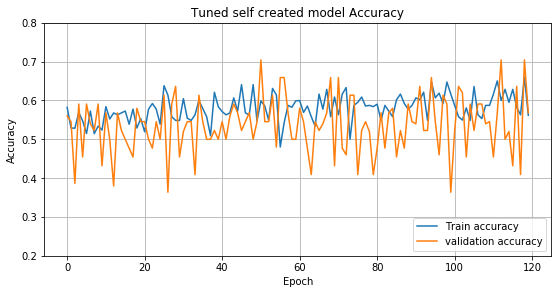

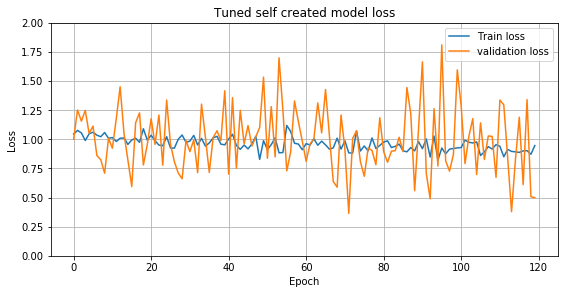

In [42]:

plt.figure(figsize=(20, 30))
plt.subplot(621)
plt.title("Tuned self created model Accuracy")
plt.plot(fin_mod3.history['accuracy'], label='Train accuracy')
plt.plot(fin_mod3.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 0.8])
plt.legend(loc='lower right')
plt.grid(True)

plt.figure(figsize=(20, 30))
plt.subplot(622)
plt.title("Tuned self created model loss")
plt.plot(fin_mod3.history['loss'], label='Train loss')
plt.plot(fin_mod3.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.legend(loc='upper right')
plt.grid(True)

#### Testing Model

In [44]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

model3.load_weights("best_model_3_task2.h5")

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=44,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model3.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 1s 15ms/step
Test loss: 1.163043737411499
Test accuracy: 0.4166666567325592


## Lower Dimension Plot

In [48]:
from sklearn.manifold import TSNE

intermediate_layer_model_3 = models.Model(inputs=model3.input,
                                        outputs=model3.get_layer('dense_158').output)

tsne_eval_generator_3 = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")


logits_3 = intermediate_layer_model_3.predict_generator(tsne_eval_generator_3,verbose=1,steps = 270)

tsne_3 = TSNE(n_components=2, init='pca', random_state = 49) 
print(logits_3.shape)
tsne_obj_3 = tsne_3.fit_transform(logits_3)



Found 270 images belonging to 4 classes.
270/270 [==============================] - 4s 14ms/step
(270, 128)


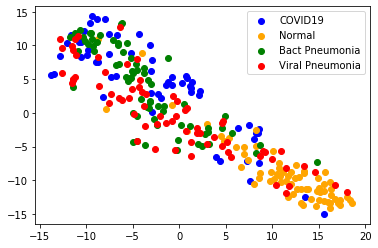

In [49]:
x1_=[]
y1_=[]

x2_=[]
y2_=[]

x3_=[]
y3_=[]

x4_=[]
y4_=[]


for i in range(tsne_obj_3.shape[0]):
    if(tsne_eval_generator_3.labels[i]==0):
        x1_.append(tsne_obj_3[i,0])
        y1_.append(tsne_obj_3[i,1])
    elif(tsne_eval_generator_3.labels[i]==1):
        x2_.append(tsne_obj_3[i,0])
        y2_.append(tsne_obj_3[i,1])
    elif(tsne_eval_generator_3.labels[i]==2):
        x3_.append(tsne_obj_3[i,0])
        y3_.append(tsne_obj_3[i,1])
    elif(tsne_eval_generator_3.labels[i]==3):
        x4_.append(tsne_obj_3[i,0])
        y4_.append(tsne_obj_3[i,1])

plt.scatter(x1_,y1_,c='blue',label = 'COVID19')
plt.scatter(x2_,y2_,c='orange',label = 'Normal')
plt.scatter(x3_,y3_,c='green',label = 'Bact Pneumonia')
plt.scatter(x4_,y4_,c='red',label = 'Viral Pneumonia')

plt.legend()

<!-- #### Renew Model -->